In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy.stats import uniform, randint
import joblib

from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.figure_factory as ff
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import poisson
from sklearn.cluster import KMeans
from scipy.stats import expon
from pandas.api.types import CategoricalDtype
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import optuna
from optuna.samplers import TPESampler
import shap
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score

In [2]:
df=pd.read_csv("fclient_churn_cluster")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170581 entries, 0 to 170580
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  170581 non-null  int64  
 1   client_id                   170581 non-null  int64  
 2   first_order_date            170581 non-null  object 
 3   last_order_date             170581 non-null  object 
 4   total_sales                 170581 non-null  float64
 5   total_quantity              170581 non-null  int64  
 6   num_tickets                 170581 non-null  int64  
 7   num_negative_tickets        170581 non-null  int64  
 8   unique_branches             170581 non-null  int64  
 9   max_days_between_orders     170581 non-null  float64
 10  total_period                170581 non-null  int64  
 11  recency                     170581 non-null  int64  
 12  avg_days_between_orders     170581 non-null  float64
 13  std_days_betwe

In [3]:
df=df.drop(columns='Unnamed: 0')

In [4]:
# Function to downcast numerical columns
def downcast_df(df):
    # Downcast floats
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    
    # Downcast integers
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
    
    # Ensure datetime columns are in datetime64[ns] format
    datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns
    df[datetime_cols] = df[datetime_cols].apply(pd.to_datetime)
    
    return df

# Apply downcasting
df = downcast_df(df)

# Display the dataframe info to check the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170581 entries, 0 to 170580
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   client_id                   170581 non-null  int32  
 1   first_order_date            170581 non-null  object 
 2   last_order_date             170581 non-null  object 
 3   total_sales                 170581 non-null  float64
 4   total_quantity              170581 non-null  int32  
 5   num_tickets                 170581 non-null  int16  
 6   num_negative_tickets        170581 non-null  int8   
 7   unique_branches             170581 non-null  int16  
 8   max_days_between_orders     170581 non-null  float32
 9   total_period                170581 non-null  int16  
 10  recency                     170581 non-null  int16  
 11  avg_days_between_orders     170581 non-null  float32
 12  std_days_between_orders     170581 non-null  float32
 13  monthly_freque

In [5]:
df['yearly_frequency']=df['num_tickets']/365

In [16]:
# Function to generate and plot the correlation matrix
def plot_correlation_matrix(df, columns=None):
    # Select specified columns or all columns if none specified
    if columns is not None:
        df = df[columns]
    
    # Compute the correlation matrix
    correlation_matrix = df.corr()
    
    # Generate a heatmap with Plotly
    fig = px.imshow(correlation_matrix,
                    text_auto=True,
                    aspect="equal",
                    color_continuous_scale='RdBu_r',
                    title='Correlation Matrix')
    
    fig.update_layout(
        xaxis_title="Variables",
        yaxis_title="Variables",
        width=1500,
        height=1500,
        margin=dict(l=50, r=50, t=50, b=50)
    )
    
    fig.show()

# Example usage
plot_correlation_matrix(df, columns=[
    'total_sales', 'total_quantity',  'num_negative_tickets',
    'percentage_negative_sales', 'unique_branches',
     'total_period', 
    'avg_days_between_orders', 'monthly_frequency',
    'avg_sale_value', 'yearly_frequency',
     'clv_yearly','median_days_between_orders'
])

In [19]:

# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'num_tickets',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_yearly'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')

    return f1

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



print("\nF1-Score:")
print(f1_score(y_test, y_pred))

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

[I 2024-07-09 15:50:05,153] A new study created in memory with name: no-name-12c1eb34-563f-484a-8be4-f9491429f5b1
[I 2024-07-09 15:50:26,564] Trial 0 finished with value: 0.809244658088343 and parameters: {'n_estimators': 104, 'max_depth': 24, 'min_samples_split': 19, 'min_samples_leaf': 17, 'bootstrap': True}. Best is trial 0 with value: 0.809244658088343.
[I 2024-07-09 15:50:56,776] Trial 8 finished with value: 0.8081894656622798 and parameters: {'n_estimators': 183, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 19, 'bootstrap': False}. Best is trial 0 with value: 0.809244658088343.
[I 2024-07-09 15:51:09,074] Trial 9 finished with value: 0.8059911481079813 and parameters: {'n_estimators': 221, 'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 0 with value: 0.809244658088343.
[I 2024-07-09 15:51:21,263] Trial 5 finished with value: 0.8100360524078905 and parameters: {'n_estimators': 382, 'max_depth': 22, 'min_samples_sp

Best parameters found: {'n_estimators': 399, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 12, 'bootstrap': True}
Confusion Matrix:
[[19569  4252]
 [ 2182  8114]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.66      0.79      0.72     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.81      0.82     34117


Accuracy Score:
0.8114136647419176

Feature Importance:
                   feature  importance
2             total_period    0.618740
1              num_tickets    0.165850
3  avg_days_between_orders    0.107051
5               clv_yearly    0.043671
0          unique_branches    0.033507
4           avg_sale_value    0.031182


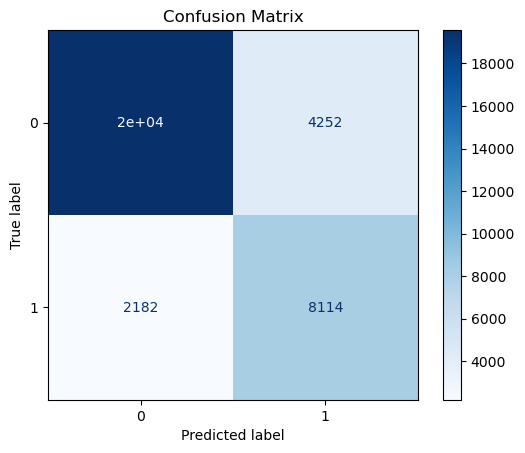

Overall F1 Score: 0.8157

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.66      0.79      0.72     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.81      0.82     34117



In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [23]:

# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

[I 2024-07-09 16:46:29,841] A new study created in memory with name: no-name-9ca57380-73ad-4b49-85b5-4d0b0639b039
[I 2024-07-09 16:47:14,978] Trial 11 finished with value: 0.8082480874637278 and parameters: {'n_estimators': 153, 'max_depth': 34, 'min_samples_split': 10, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 11 with value: 0.8082480874637278.
[I 2024-07-09 16:47:20,639] Trial 9 finished with value: 0.8056394172992936 and parameters: {'n_estimators': 159, 'max_depth': 40, 'min_samples_split': 16, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 11 with value: 0.8082480874637278.
[I 2024-07-09 16:47:22,275] Trial 8 finished with value: 0.8081601547615558 and parameters: {'n_estimators': 177, 'max_depth': 26, 'min_samples_split': 14, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 11 with value: 0.8082480874637278.
[I 2024-07-09 16:47:34,701] Trial 6 finished with value: 0.8117067737491573 and parameters: {'n_estimators': 346, 'max_depth': 42, 'min_s

Best parameters found: {'n_estimators': 664, 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 20, 'bootstrap': True}
Confusion Matrix:
[[19611  4210]
 [ 2195  8101]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.66      0.79      0.72     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.81      0.79     34117
weighted avg       0.83      0.81      0.82     34117


Accuracy Score:
0.8122636808629129

Feature Importance:
                     feature  importance
2               total_period    0.723740
3    avg_days_between_orders    0.085140
5                clv_monthly    0.062543
0            unique_branches    0.046615
6                    cluster    0.038328
4             avg_sale_value    0.036444
1  percentage_negative_sales    0.007189


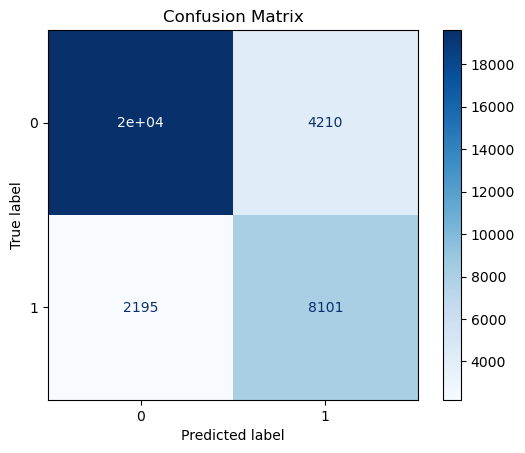

Overall F1 Score: 0.8165

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.66      0.79      0.72     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.81      0.79     34117
weighted avg       0.83      0.81      0.82     34117



In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [26]:
import plotly.express as px
import pandas as pd

# Assuming `best_rf_classifier` is the trained model and `feature_columns` is the list of feature names

# Get feature importances from the model
importances = best_rf_classifier.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=True)

# Plotting with Plotly Express
fig = px.bar(feature_importance_df, x='importance', y='feature', orientation='h', 
             title='Feature Importance', labels={'importance': 'Importance', 'feature': 'Feature'})
fig.show()

In [27]:
import plotly.express as px
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Assuming you have a trained logistic regression model
# Example training a LogisticRegression model for demonstration
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Get feature coefficients from the model
coefficients = logistic_model.coef_[0]

# Create a DataFrame for better visualization
feature_coefficients_df = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': coefficients
})

# Sort the DataFrame by absolute value of coefficients
feature_coefficients_df = feature_coefficients_df.sort_values(by='coefficient', ascending=True)

# Plotting with Plotly Express
fig = px.bar(feature_coefficients_df, x='coefficient', y='feature', orientation='h', 
             title='Feature Coefficients', labels={'coefficient': 'Coefficient', 'feature': 'Feature'})
fig.show()

/Users/paolobrambillasca/anaconda3/envs/pda_ie_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [28]:

# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster','num_tickets'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

[I 2024-07-09 18:00:30,734] A new study created in memory with name: no-name-adcb47a7-cde7-43ca-bda8-d03b8bcffac0
[I 2024-07-09 18:01:01,168] Trial 4 finished with value: 0.8088343054782073 and parameters: {'n_estimators': 156, 'max_depth': 29, 'min_samples_split': 14, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 4 with value: 0.8088343054782073.
[I 2024-07-09 18:01:13,529] Trial 10 finished with value: 0.8100067415071666 and parameters: {'n_estimators': 224, 'max_depth': 49, 'min_samples_split': 12, 'min_samples_leaf': 16, 'bootstrap': True}. Best is trial 10 with value: 0.8100067415071666.
[I 2024-07-09 18:01:49,137] Trial 8 finished with value: 0.8049359556819181 and parameters: {'n_estimators': 254, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 10 with value: 0.8100067415071666.
[I 2024-07-09 18:02:09,274] Trial 5 finished with value: 0.8087170618753114 and parameters: {'n_estimators': 495, 'max_depth': 28, 'min_sampl

Best parameters found: {'n_estimators': 874, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True}
Confusion Matrix:
[[19631  4190]
 [ 2217  8079]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.66      0.78      0.72     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.81      0.82     34117


Accuracy Score:
0.812205059061465

Feature Importance:
                     feature  importance
2               total_period    0.569487
7                num_tickets    0.147406
3    avg_days_between_orders    0.105471
5                clv_monthly    0.065838
4             avg_sale_value    0.051458
0            unique_branches    0.028473
6                    cluster    0.021163
1  percentage_negative_sales    0.010704


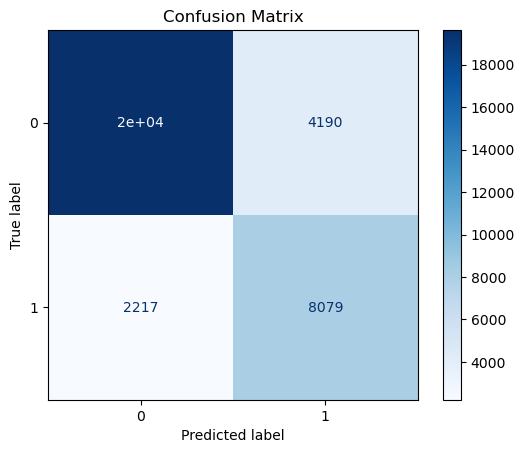

Overall F1 Score: 0.8164

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.66      0.78      0.72     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.81      0.82     34117



In [29]:
# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster'

    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster','num_tickets'

In [30]:

# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster','num_tickets', 'std_days_between_orders'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

[I 2024-07-09 18:26:33,299] A new study created in memory with name: no-name-343adf79-84a7-4701-a92b-23887a966c3c
[I 2024-07-09 18:27:27,359] Trial 11 finished with value: 0.810651581323094 and parameters: {'n_estimators': 190, 'max_depth': 50, 'min_samples_split': 16, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 11 with value: 0.810651581323094.
[I 2024-07-09 18:27:40,938] Trial 5 finished with value: 0.8145792420201072 and parameters: {'n_estimators': 276, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 5 with value: 0.8145792420201072.
[I 2024-07-09 18:28:30,001] Trial 6 finished with value: 0.8110619339332298 and parameters: {'n_estimators': 298, 'max_depth': 39, 'min_samples_split': 18, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 5 with value: 0.8145792420201072.
[I 2024-07-09 18:28:59,611] Trial 3 finished with value: 0.8144913093179353 and parameters: {'n_estimators': 593, 'max_depth': 32, 'min_samples_

Best parameters found: {'n_estimators': 116, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 8, 'bootstrap': True}
Confusion Matrix:
[[19522  4299]
 [ 1967  8329]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     23821
           1       0.66      0.81      0.73     10296

    accuracy                           0.82     34117
   macro avg       0.78      0.81      0.79     34117
weighted avg       0.83      0.82      0.82     34117


Accuracy Score:
0.816337896063546

Feature Importance:
                     feature  importance
2               total_period    0.572220
7                num_tickets    0.124792
8    std_days_between_orders    0.108003
3    avg_days_between_orders    0.082978
4             avg_sale_value    0.040900
5                clv_monthly    0.039932
0            unique_branches    0.015985
6                    cluster    0.010883
1  percentage_negative_sales    0.004308


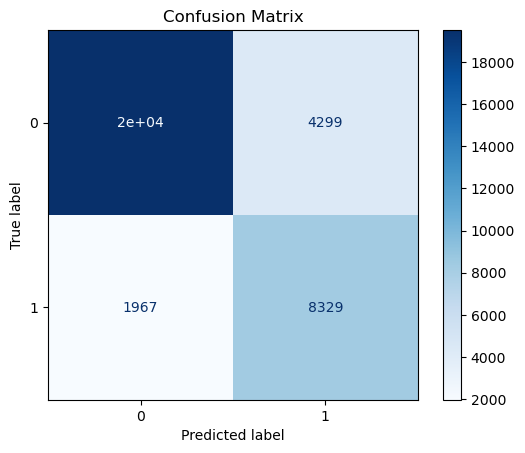

Overall F1 Score: 0.8210

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     23821
           1       0.66      0.81      0.73     10296

    accuracy                           0.82     34117
   macro avg       0.78      0.81      0.79     34117
weighted avg       0.83      0.82      0.82     34117



In [31]:
# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [32]:

# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster','num_tickets', 'std_days_between_orders','total_sales'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

[I 2024-07-09 18:44:08,937] A new study created in memory with name: no-name-91c46d7e-5b51-4c36-9154-a78c54c4de3e
[I 2024-07-09 18:44:53,958] Trial 3 finished with value: 0.812205059061465 and parameters: {'n_estimators': 105, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 18, 'bootstrap': False}. Best is trial 3 with value: 0.812205059061465.
[I 2024-07-09 18:45:21,505] Trial 4 finished with value: 0.8131430078846323 and parameters: {'n_estimators': 236, 'max_depth': 49, 'min_samples_split': 2, 'min_samples_leaf': 11, 'bootstrap': True}. Best is trial 4 with value: 0.8131430078846323.
[I 2024-07-09 18:45:33,122] Trial 11 finished with value: 0.809332590790515 and parameters: {'n_estimators': 182, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 4 with value: 0.8131430078846323.
[I 2024-07-09 18:45:42,025] Trial 6 finished with value: 0.8144619984172113 and parameters: {'n_estimators': 354, 'max_depth': 15, 'min_samples_sp

Best parameters found: {'n_estimators': 328, 'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 18, 'bootstrap': True}
Confusion Matrix:
[[20088  3733]
 [ 2568  7728]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     23821
           1       0.67      0.75      0.71     10296

    accuracy                           0.82     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.82      0.82      0.82     34117


Accuracy Score:
0.8153120145382068

Feature Importance:
                     feature  importance
2               total_period    0.499212
7                num_tickets    0.115795
8    std_days_between_orders    0.101011
9                total_sales    0.091305
3    avg_days_between_orders    0.075371
5                clv_monthly    0.049696
4             avg_sale_value    0.039304
0            unique_branches    0.016696
6                    cluster    0.008946
1  p

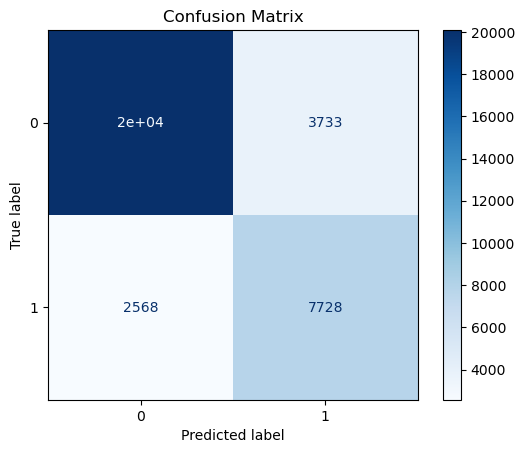

Overall F1 Score: 0.8179

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     23821
           1       0.67      0.75      0.71     10296

    accuracy                           0.82     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.82      0.82      0.82     34117



In [33]:
# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [35]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_rf_classifier)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot summary plot
shap.summary_plot(shap_values[1], X_test, plot_type="bar") 

# Optional: Detailed SHAP summary plot
shap.summary_plot(shap_values[1], X_test)

In [ ]:
# Create a copy of the DataFrame
df_copy = df.copy()

# Get predicted probabilities for the positive class (churn) on the entire dataset
churn_proba = best_rf_classifier.predict_proba(df_copy[feature_columns])[:, 1]

# Add the probabilities to the copy of the DataFrame
df_copy['churn_proba'] = churn_proba

# Create churn predictions based on the default threshold of 0.5
df_copy['churn'] = (df_copy['churn_proba'] >= 0.5).astype(int)

# Display the updated DataFrame copy with the new columns
df_copy.head()


# I now optimize for roc-auc

[I 2024-07-09 19:48:28,942] A new study created in memory with name: no-name-d4776ab7-0dd6-46f9-ac89-e7c4748d0b04
[I 2024-07-09 19:48:55,718] Trial 4 finished with value: 0.9005014090784 and parameters: {'n_estimators': 124, 'max_depth': 35, 'min_samples_split': 9, 'min_samples_leaf': 16, 'bootstrap': True}. Best is trial 4 with value: 0.9005014090784.
[I 2024-07-09 19:49:44,264] Trial 5 finished with value: 0.8976661011630157 and parameters: {'n_estimators': 234, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 13, 'bootstrap': False}. Best is trial 4 with value: 0.9005014090784.
[I 2024-07-09 19:49:50,133] Trial 8 finished with value: 0.8994365557875696 and parameters: {'n_estimators': 350, 'max_depth': 34, 'min_samples_split': 20, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 4 with value: 0.9005014090784.
[I 2024-07-09 19:50:16,458] Trial 1 finished with value: 0.897855273094033 and parameters: {'n_estimators': 442, 'max_depth': 39, 'min_samples_split': 5, 'm

Best parameters found: {'n_estimators': 886, 'max_depth': 11, 'min_samples_split': 18, 'min_samples_leaf': 17, 'bootstrap': True}
Confusion Matrix:
[[19566  4255]
 [ 2224  8072]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.65      0.78      0.71     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.82      0.81      0.81     34117


Accuracy Score:
0.8100946742093385

ROC-AUC Score: 0.9019

Feature Importance:
                   feature  importance
2             total_period    0.635311
1              num_tickets    0.167954
3  avg_days_between_orders    0.103074
5               clv_yearly    0.038371
0          unique_branches    0.030461
4           avg_sale_value    0.024828


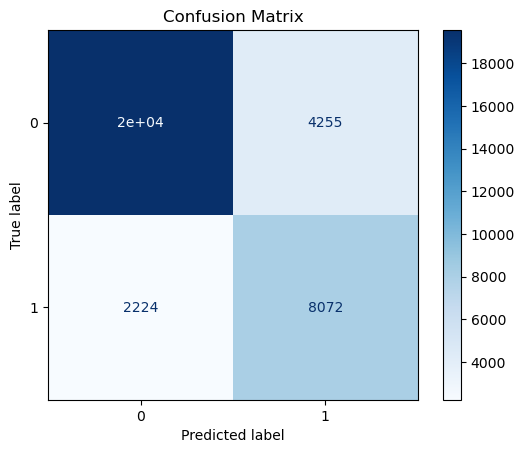

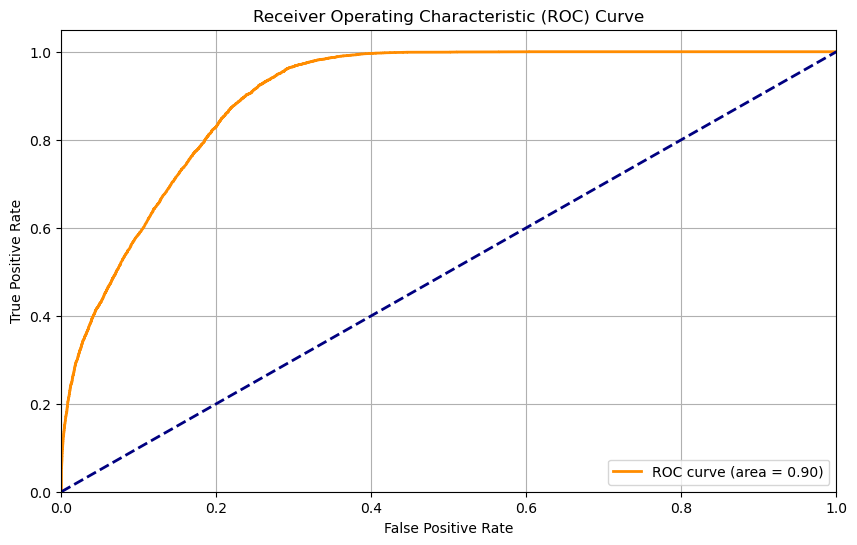

Overall F1 Score: 0.8144

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.65      0.78      0.71     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.82      0.81      0.81     34117



In [7]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it is already loaded
# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'num_tickets',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_yearly'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [8]:
# Create a copy of the DataFrame
df_copy = df.copy()

# Get predicted probabilities for the positive class (churn) on the entire dataset
churn_proba = best_rf_classifier.predict_proba(df_copy[feature_columns])[:, 1]

# Add the probabilities to the copy of the DataFrame
df_copy['churn_proba'] = churn_proba

# Create churn predictions based on the default threshold of 0.5
df_copy['churn'] = (df_copy['churn_proba'] >= 0.5).astype(int)

# Display the updated DataFrame copy with the new columns
df_copy.head()

client_id first_order_date last_order_date   total_sales  total_quantity  \
0          6       2017-10-27      2019-08-13    1642.03500             173   
1          7       2018-07-16      2018-12-24     160.03554              16   
2         14       2017-09-25      2019-09-20  138215.81000           59057   
3         18       2017-09-26      2019-09-12   53813.38700            7045   
4         25       2018-10-10      2018-10-10       9.38400              51   

   num_tickets  num_negative_tickets  unique_branches  \
0           13                     0                1   
1            2                     0                1   
2          505                     1                6   
3          291                     2                1   
4            1                     0                1   

   max_days_between_orders  total_period  recency  avg_days_between_orders  \
0                    194.0           655       40                54.583332   
1                    161.0           161      272               161.000000   
2                     10.0           725        2                 1.438492   
3                     26.0           716       10                 2.468966   
4                      0.0             0      347                 0.000000   

   std_days_between_orders  monthly_frequency  avg_sale_value    clv_monthly  \
0                66.839645           0.595420       126.31039    1804.985076   
1                 0.000000           0.372671        80.01777     715.686877   
2                 0.931120          20.896551       273.69467  137262.600000   
3                 2.595058          12.192738       184.92572   54114.020164   
4                 0.000000           0.000000         9.38400       0.000000   

      clv_yearly  median_days_between_orders  percentage_negative_sales  \
0    1804.985076                         0.0                   0.000000   
1     715.686877                         0.0                   0.000000   
2  137262.600000                         0.0                  -0.001215   
3   54114.020164                         0.0                  -0.000055   
4       0.000000                         0.0                   0.000000   

   churn_max  cluster  yearly_frequency  churn_proba  churn  
0          0        0          0.035616     0.003809      0  
1          1        0          0.005479     0.681576      1  
2          0        2          1.383562     0.014190      0  
3          0        1          0.797260     0.017650      0  
4          0        0          0.002740     0.423801      0

In [9]:
df_copy.to_csv('proba')

[I 2024-07-09 20:15:11,615] A new study created in memory with name: no-name-a576f2f9-5e27-4635-9197-982250dad20a
[I 2024-07-09 20:16:46,715] Trial 8 finished with value: 0.9011689428049992 and parameters: {'n_estimators': 469, 'max_depth': 47, 'min_samples_split': 13, 'min_samples_leaf': 15, 'bootstrap': True}. Best is trial 8 with value: 0.9011689428049992.
[I 2024-07-09 20:16:50,905] Trial 4 finished with value: 0.8983651502935958 and parameters: {'n_estimators': 327, 'max_depth': 48, 'min_samples_split': 4, 'min_samples_leaf': 12, 'bootstrap': False}. Best is trial 8 with value: 0.9011689428049992.
[I 2024-07-09 20:16:54,652] Trial 6 finished with value: 0.8951790263316857 and parameters: {'n_estimators': 322, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 8 with value: 0.9011689428049992.
[I 2024-07-09 20:16:55,560] Trial 1 finished with value: 0.8975524997417446 and parameters: {'n_estimators': 339, 'max_depth': 30, 'min_samples

Best parameters found: {'n_estimators': 756, 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 12, 'bootstrap': True}
Confusion Matrix:
[[19609  4212]
 [ 2208  8088]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.66      0.79      0.72     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.81      0.82     34117


Accuracy Score:
0.8118240173520532

ROC-AUC Score: 0.9021

Feature Importance:
                     feature  importance
2               total_period    0.712246
3    avg_days_between_orders    0.089620
5                clv_monthly    0.065305
0            unique_branches    0.045758
4             avg_sale_value    0.043630
6                    cluster    0.034601
1  percentage_negative_sales    0.008840


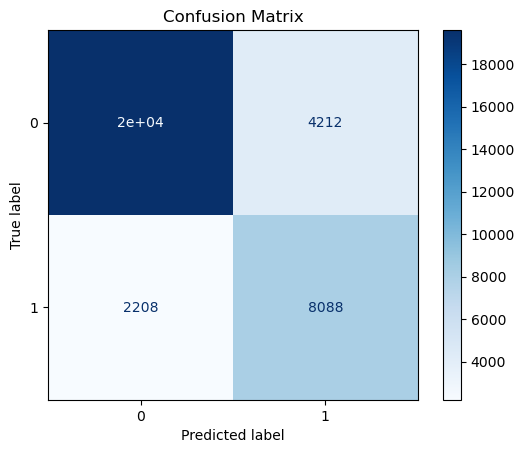

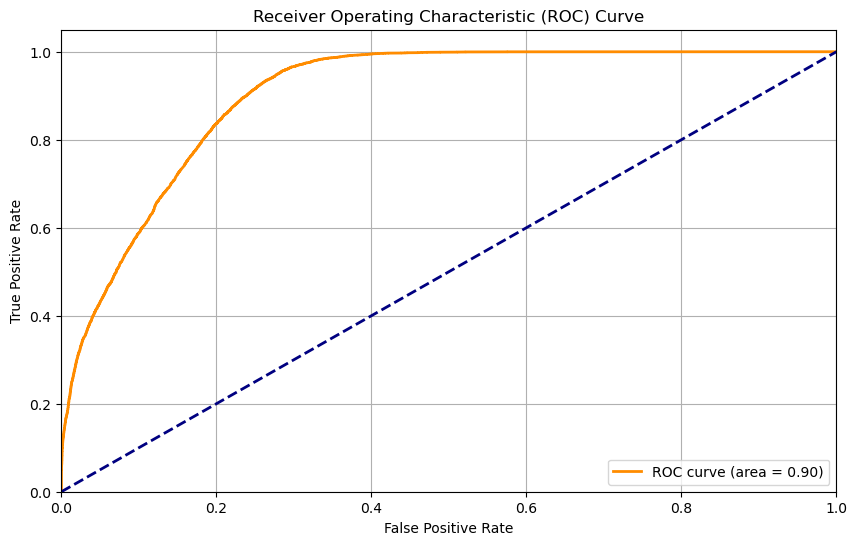

Overall F1 Score: 0.8160

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.66      0.79      0.72     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.81      0.82     34117



In [10]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it is already loaded
# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[I 2024-07-09 21:29:23,306] A new study created in memory with name: no-name-87cc05e5-2d8f-4e66-9acd-f5186b889fc6
[I 2024-07-09 21:29:50,543] Trial 3 finished with value: 0.9014708782744341 and parameters: {'n_estimators': 180, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 18, 'bootstrap': True}. Best is trial 3 with value: 0.9014708782744341.
[I 2024-07-09 21:29:53,912] Trial 1 finished with value: 0.9018100699705166 and parameters: {'n_estimators': 249, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 1 with value: 0.9018100699705166.
[I 2024-07-09 21:30:31,448] Trial 9 finished with value: 0.8975061552383032 and parameters: {'n_estimators': 213, 'max_depth': 50, 'min_samples_split': 11, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 1 with value: 0.9018100699705166.
[I 2024-07-09 21:30:54,260] Trial 4 finished with value: 0.9015462673448275 and parameters: {'n_estimators': 622, 'max_depth': 20, 'min_samples_s

Best parameters found: {'n_estimators': 826, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 6, 'bootstrap': True}
Confusion Matrix:
[[19618  4203]
 [ 2235  8061]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.66      0.78      0.71     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.81      0.82     34117


Accuracy Score:
0.8112964211390216

ROC-AUC Score: 0.9021

Feature Importance:
                     feature  importance
2               total_period    0.580144
7                num_tickets    0.153118
3    avg_days_between_orders    0.105966
5                clv_monthly    0.059350
4             avg_sale_value    0.043256
0            unique_branches    0.028251
6                    cluster    0.022906
1  percentage_negative_sales    0.007009


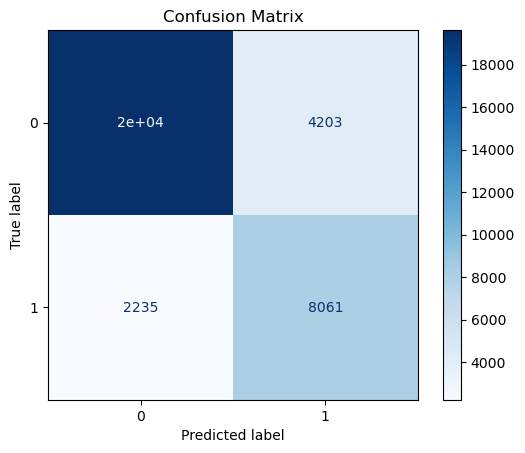

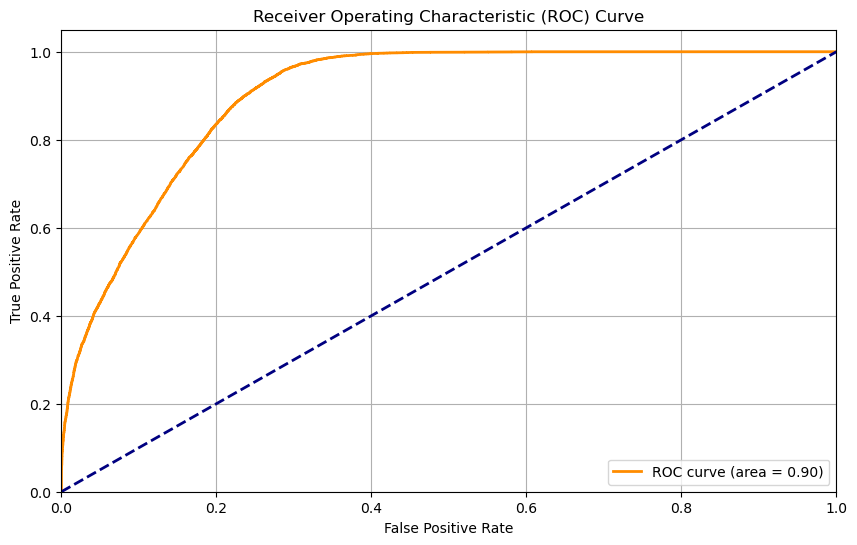

Overall F1 Score: 0.8155

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.66      0.78      0.71     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.81      0.82     34117



In [14]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it is already loaded
# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster','num_tickets'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=8)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[I 2024-07-09 21:48:51,236] A new study created in memory with name: no-name-f7ce7955-1ae7-46ca-9a77-028b5cd131be
[I 2024-07-09 21:49:50,125] Trial 6 finished with value: 0.903088106346261 and parameters: {'n_estimators': 191, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 6 with value: 0.903088106346261.
[I 2024-07-09 21:50:49,483] Trial 2 finished with value: 0.904868531980639 and parameters: {'n_estimators': 410, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 18, 'bootstrap': False}. Best is trial 2 with value: 0.904868531980639.
[I 2024-07-09 21:51:09,799] Trial 8 finished with value: 0.9063948120479122 and parameters: {'n_estimators': 394, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 11, 'bootstrap': True}. Best is trial 8 with value: 0.9063948120479122.
[I 2024-07-09 21:51:15,889] Trial 4 finished with value: 0.9061002992827852 and parameters: {'n_estimators': 949, 'max_depth': 11, 'min_samples_spli

Best parameters found: {'n_estimators': 520, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 18, 'bootstrap': True}
Confusion Matrix:
[[19655  4166]
 [ 2153  8143]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     23821
           1       0.66      0.79      0.72     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.81      0.79     34117
weighted avg       0.83      0.81      0.82     34117


Accuracy Score:
0.8147844183251751

ROC-AUC Score: 0.9068

Feature Importance:
                     feature  importance
2               total_period    0.566405
7                num_tickets    0.129151
8    std_days_between_orders    0.107838
3    avg_days_between_orders    0.083366
4             avg_sale_value    0.042262
5                clv_monthly    0.037059
0            unique_branches    0.018941
6                    cluster    0.011836
1  percentage_negativ

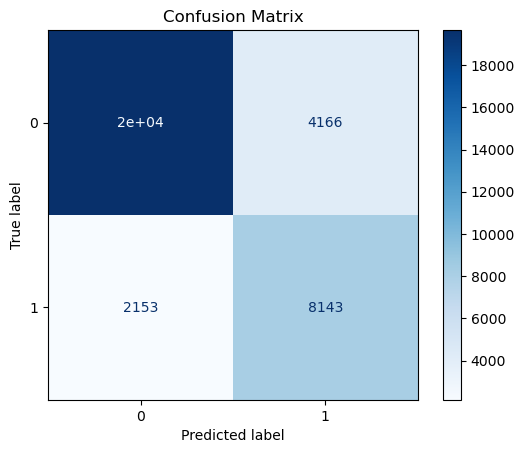

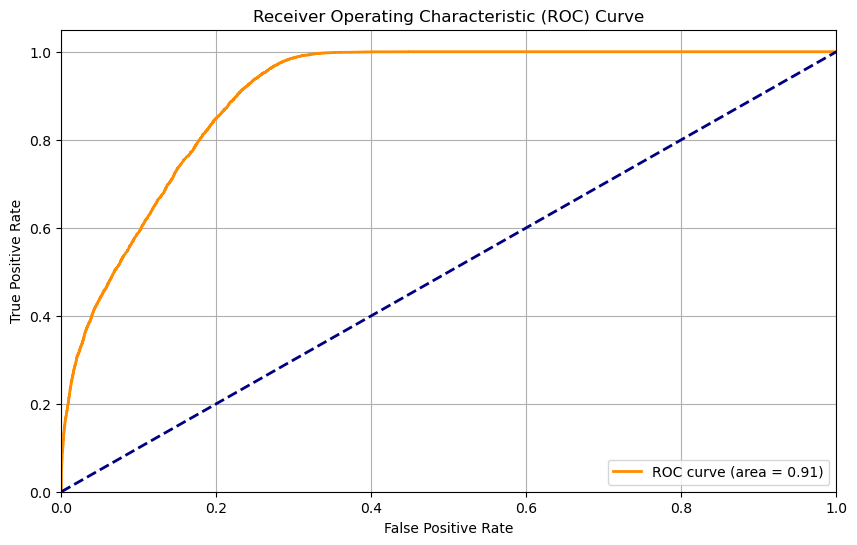

Overall F1 Score: 0.8189

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     23821
           1       0.66      0.79      0.72     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.81      0.79     34117
weighted avg       0.83      0.81      0.82     34117



In [15]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it is already loaded
# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster','num_tickets', 'std_days_between_orders'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=8)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[I 2024-07-09 22:17:25,753] A new study created in memory with name: no-name-fe945ed0-53de-40ae-ac57-a4fa6de1e240
[I 2024-07-09 22:17:57,155] Trial 6 finished with value: 0.9058339075786916 and parameters: {'n_estimators': 142, 'max_depth': 42, 'min_samples_split': 8, 'min_samples_leaf': 17, 'bootstrap': True}. Best is trial 6 with value: 0.9058339075786916.
[I 2024-07-09 22:18:29,821] Trial 3 finished with value: 0.9012496568145995 and parameters: {'n_estimators': 181, 'max_depth': 48, 'min_samples_split': 19, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 6 with value: 0.9058339075786916.
[I 2024-07-09 22:18:43,978] Trial 1 finished with value: 0.905826796786979 and parameters: {'n_estimators': 347, 'max_depth': 42, 'min_samples_split': 12, 'min_samples_leaf': 14, 'bootstrap': True}. Best is trial 6 with value: 0.9058339075786916.
[I 2024-07-09 22:19:50,528] Trial 5 finished with value: 0.9058688540212195 and parameters: {'n_estimators': 852, 'max_depth': 11, 'min_samples_

Best parameters found: {'n_estimators': 638, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 19, 'bootstrap': True}
Confusion Matrix:
[[19773  4048]
 [ 2283  8013]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     23821
           1       0.66      0.78      0.72     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.81      0.82     34117


Accuracy Score:
0.8144326875164873

ROC-AUC Score: 0.9066

Feature Importance:
                     feature  importance
2               total_period    0.517562
7                num_tickets    0.120031
8    std_days_between_orders    0.099505
9                total_sales    0.081195
3    avg_days_between_orders    0.074661
5                clv_monthly    0.049170
4             avg_sale_value    0.030964
0            unique_branches    0.015455
6                    c

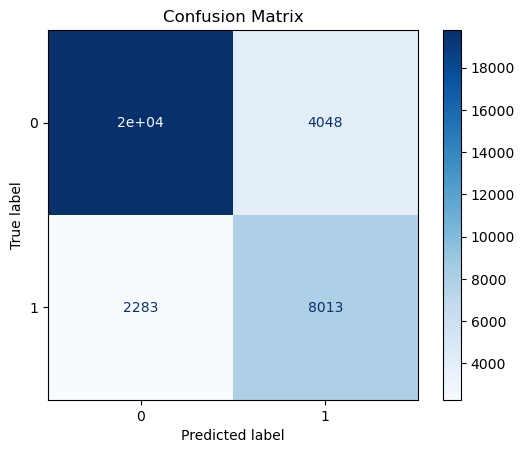

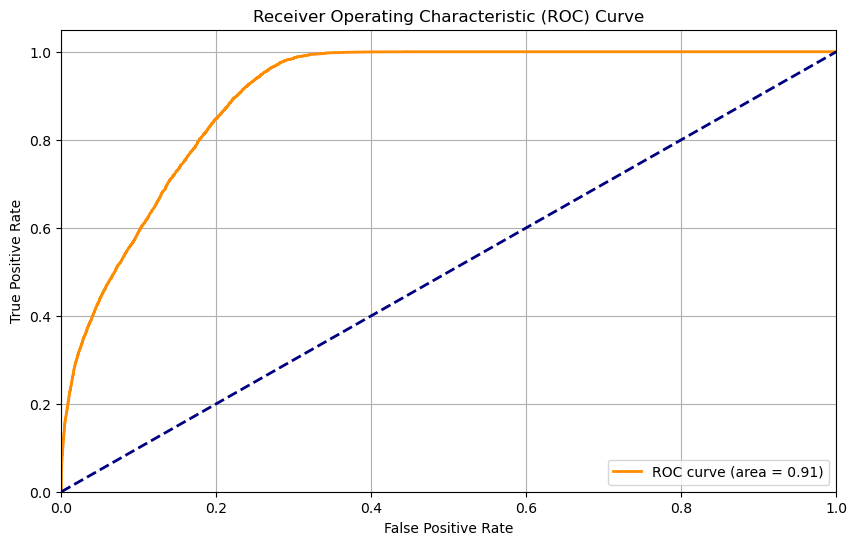

Overall F1 Score: 0.8182

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     23821
           1       0.66      0.78      0.72     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.81      0.82     34117



In [16]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it is already loaded
# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster','num_tickets', 'std_days_between_orders','total_sales'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=8)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[I 2024-07-09 22:50:52,660] A new study created in memory with name: no-name-2407b256-b4f7-4d87-91b7-0ffb59ebe3d4
[I 2024-07-09 22:51:17,084] Trial 6 finished with value: 0.9060584357197642 and parameters: {'n_estimators': 110, 'max_depth': 38, 'min_samples_split': 12, 'min_samples_leaf': 12, 'bootstrap': True}. Best is trial 6 with value: 0.9060584357197642.
[I 2024-07-09 22:51:30,167] Trial 3 finished with value: 0.9039540959905344 and parameters: {'n_estimators': 107, 'max_depth': 48, 'min_samples_split': 16, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 6 with value: 0.9060584357197642.
[I 2024-07-09 22:51:35,610] Trial 0 finished with value: 0.9049790244691802 and parameters: {'n_estimators': 184, 'max_depth': 44, 'min_samples_split': 16, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 6 with value: 0.9060584357197642.
[I 2024-07-09 22:51:52,326] Trial 9 finished with value: 0.9064402269295012 and parameters: {'n_estimators': 101, 'max_depth': 18, 'min_sample

Best parameters found: {'n_estimators': 560, 'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 10, 'bootstrap': True}
Confusion Matrix:
[[19687  4134]
 [ 2133  8163]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     23821
           1       0.66      0.79      0.72     10296

    accuracy                           0.82     34117
   macro avg       0.78      0.81      0.79     34117
weighted avg       0.83      0.82      0.82     34117


Accuracy Score:
0.816308585162822

ROC-AUC Score: 0.9069

Feature Importance:
                      feature  importance
2                total_period    0.477123
7                 num_tickets    0.111373
8     std_days_between_orders    0.093879
3     avg_days_between_orders    0.082607
9                 total_sales    0.079768
10             total_quantity    0.054720
5                 clv_monthly    0.049628
4              avg_sale_value    0.033623
0            

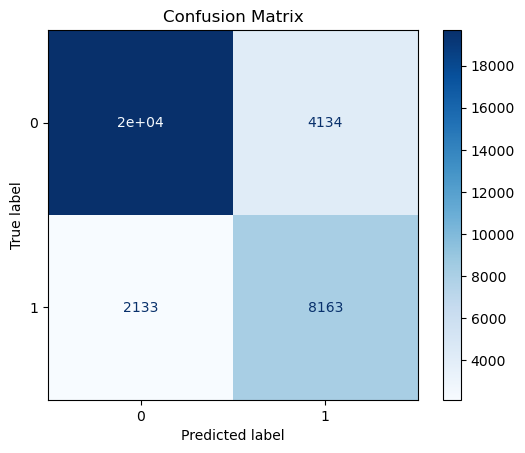

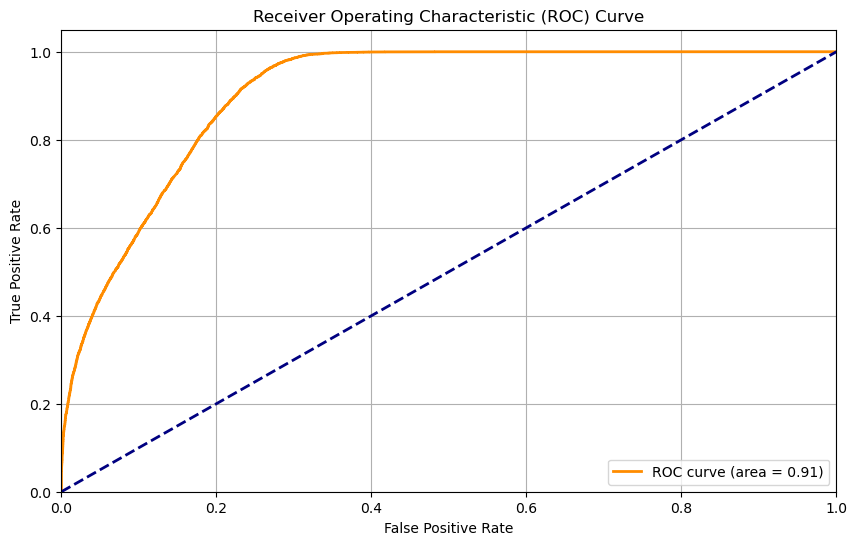

Overall F1 Score: 0.8204

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     23821
           1       0.66      0.79      0.72     10296

    accuracy                           0.82     34117
   macro avg       0.78      0.81      0.79     34117
weighted avg       0.83      0.82      0.82     34117



In [17]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it is already loaded
# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster','num_tickets', 'std_days_between_orders','total_sales', 'total_quantity'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=8)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[I 2024-07-10 09:52:53,869] A new study created in memory with name: no-name-76734125-cf3e-417c-8ccd-d6ba9021353a
[I 2024-07-10 09:54:24,419] Trial 5 finished with value: 0.9058407248056087 and parameters: {'n_estimators': 394, 'max_depth': 35, 'min_samples_split': 16, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 5 with value: 0.9058407248056087.
[I 2024-07-10 09:54:34,172] Trial 6 finished with value: 0.9066858693107591 and parameters: {'n_estimators': 473, 'max_depth': 35, 'min_samples_split': 9, 'min_samples_leaf': 17, 'bootstrap': True}. Best is trial 6 with value: 0.9066858693107591.
[I 2024-07-10 09:54:52,773] Trial 3 finished with value: 0.9047145022020132 and parameters: {'n_estimators': 346, 'max_depth': 43, 'min_samples_split': 11, 'min_samples_leaf': 11, 'bootstrap': False}. Best is trial 6 with value: 0.9066858693107591.
[I 2024-07-10 09:54:57,661] Trial 4 finished with value: 0.9054516046692068 and parameters: {'n_estimators': 793, 'max_depth': 10, 'min_samples

Best parameters found: {'n_estimators': 956, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 20, 'bootstrap': True}
Confusion Matrix:
[[19826  3995]
 [ 2310  7986]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     23821
           1       0.67      0.78      0.72     10296

    accuracy                           0.82     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.82      0.82     34117


Accuracy Score:
0.8151947709353109

ROC-AUC Score: 0.9069

Feature Importance:
                      feature  importance
2                total_period    0.498501
7                 num_tickets    0.114486
8     std_days_between_orders    0.089875
3     avg_days_between_orders    0.078957
9                 total_sales    0.076273
10             total_quantity    0.052110
5                 clv_monthly    0.046368
4              avg_sale_value    0.027675
0            

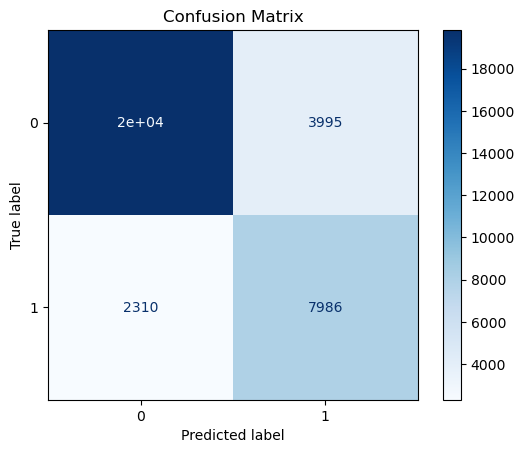

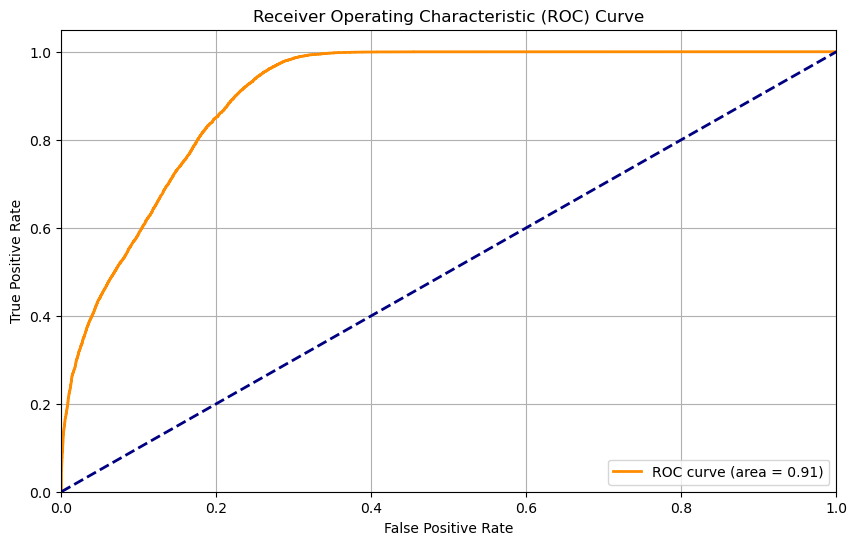

Overall F1 Score: 0.8188

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     23821
           1       0.67      0.78      0.72     10296

    accuracy                           0.82     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.82      0.82     34117



In [25]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it is already loaded
# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster','num_tickets', 'std_days_between_orders','total_sales', 'total_quantity'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=8)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

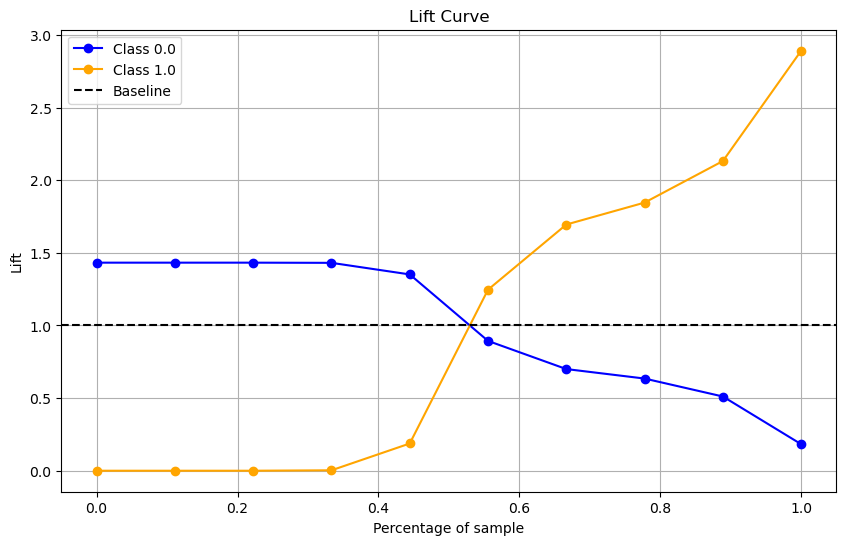

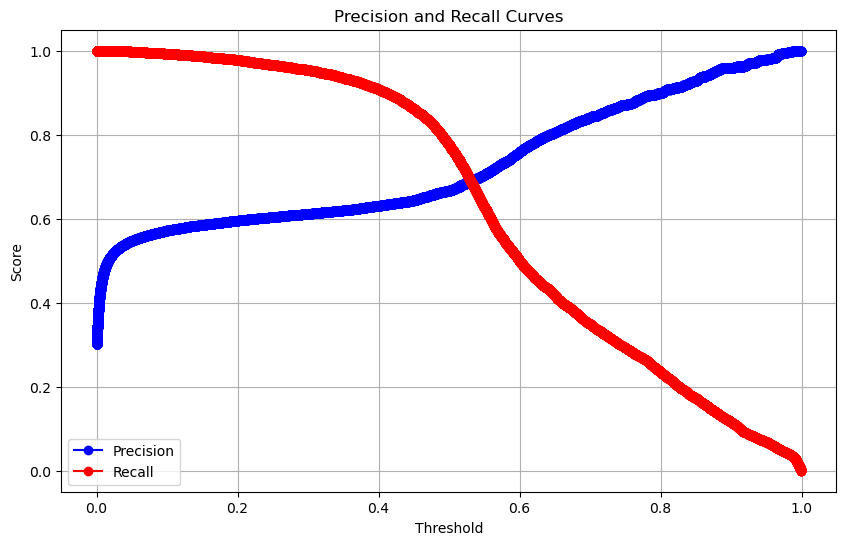

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve

feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster','num_tickets', 'std_days_between_orders','total_sales', 'total_quantity'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train the model with the best parameters
clf = RandomForestClassifier(
    n_estimators=956,
    max_depth=23,
    min_samples_split=3,
    min_samples_leaf=20,
    bootstrap=True,
    random_state=42
)
clf.fit(X_train, y_train)

# Step 3: Make predictions
y_proba = clf.predict_proba(X_test)[:, 1]

# Step 4: Calculate lift
def calculate_lift(y_true, y_proba, n_bins=10):
    data = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    data = data.sort_values(by='y_proba', ascending=False)
    data['bin'] = pd.qcut(data['y_proba'], n_bins, labels=False)

    lift = []
    for i in range(n_bins):
        bin_data = data[data['bin'] == i]
        lift.append(bin_data['y_true'].mean() / data['y_true'].mean())
    return lift

lift = calculate_lift(y_test, y_proba)

# Plot the lift curve similar to the provided example
def plot_lift_curve(y_true, y_proba, n_bins=10):
    data = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    data = data.sort_values(by='y_proba', ascending=False)
    data['bin'] = pd.qcut(data['y_proba'], n_bins, labels=False)
    
    lift_class_1 = []
    lift_class_0 = []
    for i in range(n_bins):
        bin_data = data[data['bin'] == i]
        lift_class_1.append(bin_data['y_true'].sum() / len(bin_data) / data['y_true'].mean())
        lift_class_0.append((1 - bin_data['y_true']).sum() / len(bin_data) / (1 - data['y_true'].mean()))

    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(0, 1, n_bins), lift_class_0, marker='o', linestyle='-', color='b', label='Class 0.0')
    plt.plot(np.linspace(0, 1, n_bins), lift_class_1, marker='o', linestyle='-', color='orange', label='Class 1.0')
    plt.axhline(1, color='black', linestyle='--', label='Baseline')
    plt.title('Lift Curve')
    plt.xlabel('Percentage of sample')
    plt.ylabel('Lift')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_lift_curve(y_test, y_proba)

# Combined Precision and Recall Curve Code
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], marker='o', linestyle='-', color='b', label='Precision')
plt.plot(thresholds, recall[:-1], marker='o', linestyle='-', color='r', label='Recall')
plt.title('Precision and Recall Curves')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.show()

Analysis of the Lift Curve:

	1.	Class 1.0 (Orange Line):
	•	The lift for Class 1.0 starts high and decreases as we move through the deciles. This means that the model is good at identifying the positive class (Class 1.0) at the higher probability deciles.
	•	Initially, the lift is above 3, indicating that the proportion of positive instances in the top deciles is more than three times the overall proportion of positives in the dataset.
	•	The lift decreases and converges towards 1 as we include more samples, which is expected because as the deciles increase, they include more of the overall population, including both positives and negatives.


	2.	Class 0.0 (Blue Line):
	•	The lift for Class 0.0 starts lower and increases as we move through the deciles. This suggests that the model is less effective at identifying the negative class (Class 0.0) at the higher probability deciles.
	•	The initial lift is below 1, indicating that the proportion of negative instances in the top deciles is less than the overall proportion of negatives in the dataset.
	•	The lift increases and crosses 1 as we move towards the lower probability deciles, suggesting that the lower deciles are enriched with negative instances.
	3.	Baseline (Dashed Line):
	•	The baseline lift is set at 1, which represents no model (random selection). Any lift above 1 indicates better-than-random performance, and below 1 indicates worse-than-random performance.

	1.	Precision (Blue Line):
	•	Precision decreases as the threshold decreases. This is expected because lower thresholds include more instances, increasing the number of false positives.
	•	The precision starts at around 1 and gradually decreases, suggesting that the top predictions (high thresholds) are very precise (few false positives).
	2.	Recall (Red Line):
	•	Recall increases as the threshold decreases. This is because lower thresholds include more true positives.
	•	The recall starts low and increases to 1, indicating that as the threshold decreases, the model captures more true positives but also includes more false positives.

Trying the previous model with these parameters: Best parameters found: {'n_estimators': 560, 'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 10, 'bootstrap': True}

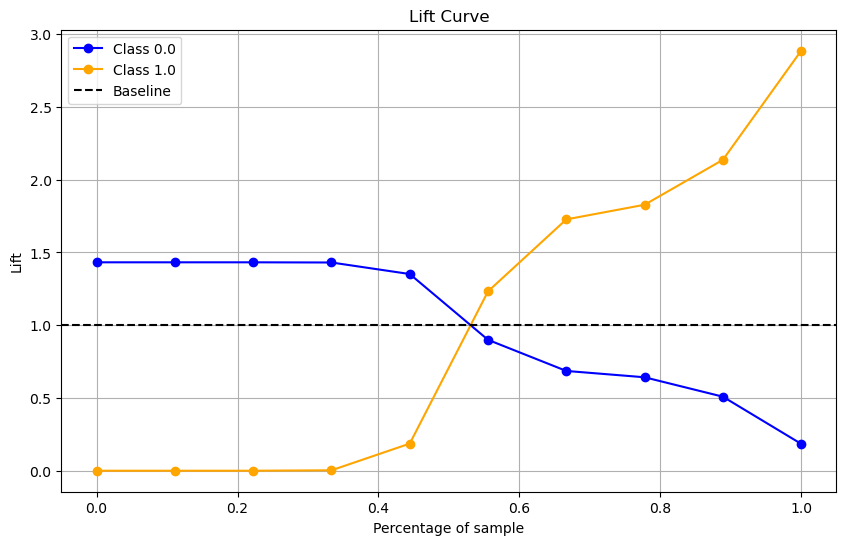

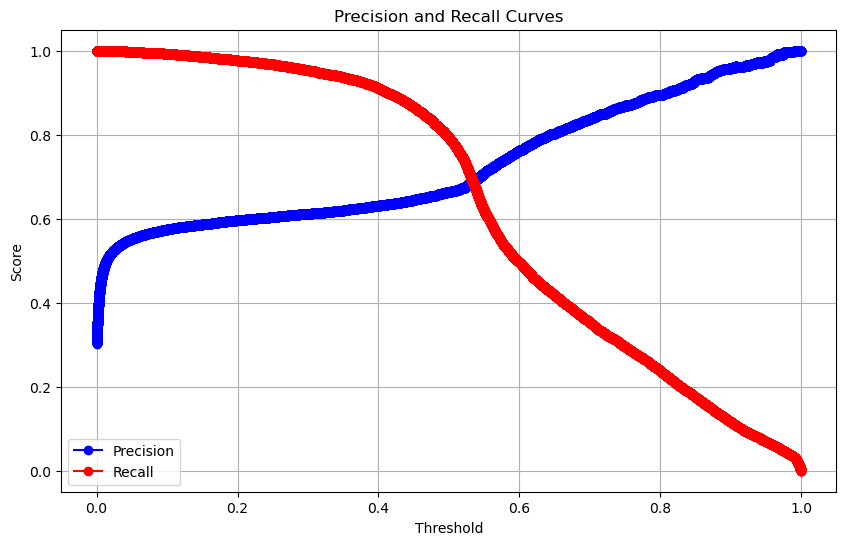

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve

feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster','num_tickets', 'std_days_between_orders','total_sales', 'total_quantity'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train the model with the best parameters
clf = RandomForestClassifier(
    n_estimators=560,
    max_depth=19,
    min_samples_split=18,
    min_samples_leaf=10,
    bootstrap=True,
    random_state=42
)
clf.fit(X_train, y_train)

# Step 3: Make predictions
y_proba = clf.predict_proba(X_test)[:, 1]

# Step 4: Calculate lift
def calculate_lift(y_true, y_proba, n_bins=10):
    data = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    data = data.sort_values(by='y_proba', ascending=False)
    data['bin'] = pd.qcut(data['y_proba'], n_bins, labels=False)

    lift = []
    for i in range(n_bins):
        bin_data = data[data['bin'] == i]
        lift.append(bin_data['y_true'].mean() / data['y_true'].mean())
    return lift

lift = calculate_lift(y_test, y_proba)

# Plot the lift curve similar to the provided example
def plot_lift_curve(y_true, y_proba, n_bins=10):
    data = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    data = data.sort_values(by='y_proba', ascending=False)
    data['bin'] = pd.qcut(data['y_proba'], n_bins, labels=False)
    
    lift_class_1 = []
    lift_class_0 = []
    for i in range(n_bins):
        bin_data = data[data['bin'] == i]
        lift_class_1.append(bin_data['y_true'].sum() / len(bin_data) / data['y_true'].mean())
        lift_class_0.append((1 - bin_data['y_true']).sum() / len(bin_data) / (1 - data['y_true'].mean()))

    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(0, 1, n_bins), lift_class_0, marker='o', linestyle='-', color='b', label='Class 0.0')
    plt.plot(np.linspace(0, 1, n_bins), lift_class_1, marker='o', linestyle='-', color='orange', label='Class 1.0')
    plt.axhline(1, color='black', linestyle='--', label='Baseline')
    plt.title('Lift Curve')
    plt.xlabel('Percentage of sample')
    plt.ylabel('Lift')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_lift_curve(y_test, y_proba)

# Combined Precision and Recall Curve Code
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], marker='o', linestyle='-', color='b', label='Precision')
plt.plot(thresholds, recall[:-1], marker='o', linestyle='-', color='r', label='Recall')
plt.title('Precision and Recall Curves')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.show()

# now we try XG Boost

[I 2024-07-10 12:40:03,832] A new study created in memory with name: no-name-c9bc802b-3c7c-42ab-b174-18899aa7b619
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/3696432574.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/3696432574.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/3696432574.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.

Best parameters found: {'n_estimators': 330, 'max_depth': 9, 'learning_rate': 0.026176374915194305, 'gamma': 2.2238511508440008e-08, 'min_child_weight': 9, 'subsample': 0.5250888961735347, 'colsample_bytree': 0.9635729901113839, 'reg_alpha': 2.1185196868254303e-08, 'reg_lambda': 5.566916301242831e-06}
Confusion Matrix:
[[19428  4393]
 [ 1853  8443]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     23821
           1       0.66      0.82      0.73     10296

    accuracy                           0.82     34117
   macro avg       0.79      0.82      0.80     34117
weighted avg       0.84      0.82      0.82     34117


Accuracy Score:
0.8169241140780256

ROC-AUC Score: 0.9073

Feature Importance:
                      feature  importance
2                total_period    0.556357
7                 num_tickets    0.104726
8     std_days_between_orders    0.072950
3     avg_days_between_orders    0.063584
9      

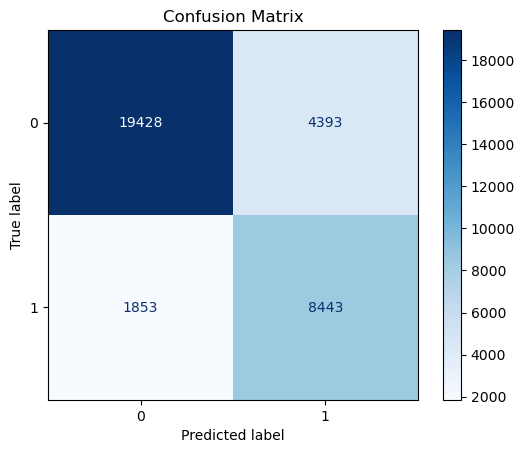

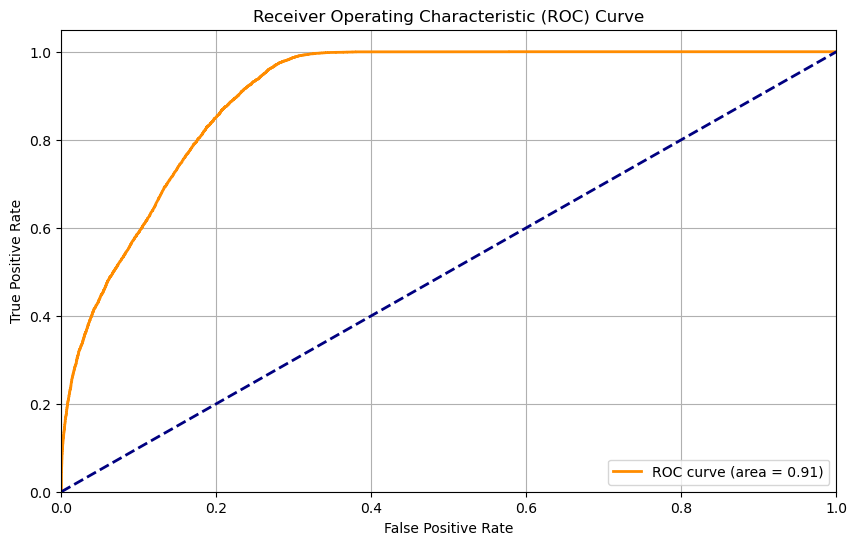

Overall F1 Score: 0.8218

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     23821
           1       0.66      0.82      0.73     10296

    accuracy                           0.82     34117
   macro avg       0.79      0.82      0.80     34117
weighted avg       0.84      0.82      0.82     34117



In [7]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it is already loaded
# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster','num_tickets', 'std_days_between_orders','total_sales', 'total_quantity'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    xgb_classifier = xgb.XGBClassifier(**param, use_label_encoder=False)
    xgb_classifier.fit(X_train, y_train)
    y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_xgb_classifier = xgb.XGBClassifier(**best_params, use_label_encoder=False)
best_xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_classifier.predict(X_test)
y_pred_proba = best_xgb_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_xgb_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[I 2024-07-10 13:03:27,647] A new study created in memory with name: no-name-baf9ed9b-ae06-48de-af75-e9162f4096c1
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Inf

[I 2024-07-10 13:03:43,011] Trial 4 finished with value: 0.905547353681353 and parameters: {'n_estimators': 449, 'max_depth': 5, 'learning_rate': 0.06736503919404364, 'num_leaves': 252, 'min_child_samples': 61, 'subsample': 0.8720794645517469, 'colsample_bytree': 0.6912183658606594, 'reg_alpha': 0.09100510409477858, 'reg_lambda': 0.8176834069035114}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScor

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:03:49,394] Trial 7 finished with value: 0.9053082227303502 and parameters: {'n_estimators': 105, 'max_depth': 24, 'learning_rate': 0.1244311778099554, 'num_leaves': 123, 'min_child_samples': 74, 'subsample': 0.7115892683811627, 'colsample_bytree': 0.7936093607311177, 'reg_alpha': 0.001000325548236086, 'reg_lambda': 0.00010066504877065829}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:03:53,536] Trial 8 finished with value: 0.9007507373287567 and parameters: {'n_estimators': 188, 'max_depth': 5, 'learning_rate': 0.010984493778150214, 'num_leaves': 103, 'min_child_samples': 83, 'subsample': 0.6822223326265987, 'colsample_bytree': 0.5722812455782127, 'reg_alpha': 0.001522636517787925, 'reg_lambda': 4.888244594399712e-07}. Best is trial 4 with value: 0.905547353681353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/ta

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:03:56,951] Trial 6 finished with value: 0.9014564895221668 and parameters: {'n_estimators': 404, 'max_depth': 7, 'learning_rate': 0.14964096555279635, 'num_leaves': 250, 'min_child_samples': 44, 'subsample': 0.7000182729551121, 'colsample_bytree': 0.8744241921315508, 'reg_alpha': 0.0021487081957770084, 'reg_lambda': 0.001930579007607792}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:04:06,532] Trial 3 finished with value: 0.9055270752853767 and parameters: {'n_estimators': 859, 'max_depth': 18, 'learning_rate': 0.034533450178116064, 'num_leaves': 24, 'min_child_samples': 7, 'subsample': 0.9301229463728592, 'colsample_bytree': 0.5929723356319917, 'reg_alpha': 0.0971100984563335, 'reg_lambda': 1.9306013507216972e-08}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-07-10 13:04:13,592] Trial 1 finished with value: 0.8985534965736258 and parameters: {'n_estimators': 528, 'max_depth': 8, 'learning_rate': 0.20970238877180392, 'num_leaves': 85, 'min_child_samples': 98, 'subsample': 0.8485833561879175, 'colsample_bytree': 0.814031087435481, 'reg_alpha': 0.00017544296922663427, 'reg_lambda': 0.0002771718745456568}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:04:21,431] Trial 9 finished with value: 0.9031350216701377 and parameters: {'n_estimators': 209, 'max_depth': 11, 'learning_rate': 0.13170187035065944, 'num_leaves': 114, 'min_child_samples': 61, 'subsample': 0.5369359501083677, 'colsample_bytree': 0.905966694222627, 'reg_alpha': 0.0018301830582401256, 'reg_lambda': 0.00018933849554076217}. Best is trial 4 with value: 0.905547353681353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:04:35,780] Trial 14 finished with value: 0.9050518856205015 and parameters: {'n_estimators': 953, 'max_depth': 23, 'learning_rate': 0.11402881734620508, 'num_leaves': 8, 'min_child_samples': 16, 'subsample': 0.7286509486714576, 'colsample_bytree': 0.9963999040187943, 'reg_alpha': 1.6710788911991087e-07, 'reg_lambda': 0.0034651016375420087}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-07-10 13:04:37,125] Trial 0 finished with value: 0.9042237067141563 and parameters: {'n_estimators': 595, 'max_depth': 16, 'learning_rate': 0.06673518563482504, 'num_leaves': 73, 'min_child_samples': 65, 'subsample': 0.5400628109610356, 'colsample_bytree': 0.9196783530639951, 'reg_alpha': 0.0010579636563635615, 'reg_lambda': 3.121477480117283e-07}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:04:52,372] Trial 5 finished with value: 0.9015096288274366 and parameters: {'n_estimators': 798, 'max_depth': 8, 'learning_rate': 0.10566751504277645, 'num_leaves': 114, 'min_child_samples': 71, 'subsample': 0.5151163805994059, 'colsample_bytree': 0.60913801534955, 'reg_alpha': 2.6515927495108956e-08, 'reg_lambda': 0.4721262530852666}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:04:54,765] Trial 15 finished with value: 0.9053062350520477 and parameters: {'n_estimators': 177, 'max_depth': 30, 'learning_rate': 0.02992511271732095, 'num_leaves': 44, 'min_child_samples': 20, 'subsample': 0.7225070131351334, 'colsample_bytree': 0.6134341729522188, 'reg_alpha': 9.363917895215758e-05, 'reg_lambda': 5.308355014860602e-05}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:04:57,977] Trial 12 finished with value: 0.8994425636726547 and parameters: {'n_estimators': 294, 'max_depth': 18, 'learning_rate': 0.17722906556312878, 'num_leaves': 105, 'min_child_samples': 75, 'subsample': 0.5851806460756548, 'colsample_bytree': 0.9754178020136188, 'reg_alpha': 6.165183149019993e-05, 'reg_lambda': 8.338482950789519e-07}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:05:08,549] Trial 16 finished with value: 0.9052906333063547 and parameters: {'n_estimators': 451, 'max_depth': 6, 'learning_rate': 0.01948947578626116, 'num_leaves': 223, 'min_child_samples': 74, 'subsample': 0.5211166662675735, 'colsample_bytree': 0.6433436952484333, 'reg_alpha': 3.247667358896236e-05, 'reg_lambda': 1.390070168002334e-08}. Best is trial 4 with value: 0.905547353681353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/t

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-07-10 13:05:43,245] Trial 2 finished with value: 0.9027426845528521 and parameters: {'n_estimators': 289, 'max_depth': 28, 'learning_rate': 0.07535277393364322, 'num_leaves': 247, 'min_child_samples': 12, 'subsample': 0.8778631646409438, 'colsample_bytree': 0.5477274166861815, 'reg_alpha': 8.518086997892346e-08, 'reg_lambda': 0.06711282188832604}. Best is trial 4 with value: 0.905547353681353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:06:23,755] Trial 13 finished with value: 0.9035010500812732 and parameters: {'n_estimators': 752, 'max_depth': 27, 'learning_rate': 0.05879949168274054, 'num_leaves': 94, 'min_child_samples': 72, 'subsample': 0.8678471458437456, 'colsample_bytree': 0.5633115642978905, 'reg_alpha': 5.931130086114997e-07, 'reg_lambda': 1.7420358191336135e-07}. Best is trial 4 with value: 0.905547353681353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:06:54,863] Trial 17 finished with value: 0.9046066130623873 and parameters: {'n_estimators': 380, 'max_depth': 14, 'learning_rate': 0.0308241302873769, 'num_leaves': 251, 'min_child_samples': 42, 'subsample': 0.9907722535936281, 'colsample_bytree': 0.6890318351260343, 'reg_alpha': 0.9535535701582913, 'reg_lambda': 0.8998346200340912}. Best is trial 4 with value: 0.905547353681353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:07:24,528] Trial 11 finished with value: 0.8970329512130863 and parameters: {'n_estimators': 732, 'max_depth': 18, 'learning_rate': 0.12919574025075967, 'num_leaves': 181, 'min_child_samples': 31, 'subsample': 0.5664344266275301, 'colsample_bytree': 0.5464695791474019, 'reg_alpha': 1.6800055634719738e-08, 'reg_lambda': 0.021644075832946}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:07:45,519] Trial 10 finished with value: 0.895134565535682 and parameters: {'n_estimators': 647, 'max_depth': 19, 'learning_rate': 0.1510184693439474, 'num_leaves': 241, 'min_child_samples': 48, 'subsample': 0.7631703246391702, 'colsample_bytree': 0.878247807218955, 'reg_alpha': 9.464406833366648e-08, 'reg_lambda': 0.04832793409192345}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:08:08,692] Trial 20 finished with value: 0.9030988561182507 and parameters: {'n_estimators': 704, 'max_depth': 14, 'learning_rate': 0.04444419524044746, 'num_leaves': 171, 'min_child_samples': 41, 'subsample': 0.97114670092648, 'colsample_bytree': 0.512406958656338, 'reg_alpha': 0.8211706819967579, 'reg_lambda': 0.4234949692430888}. Best is trial 4 with value: 0.905547353681353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:08:18,683] Trial 26 finished with value: 0.905509657107512 and parameters: {'n_estimators': 841, 'max_depth': 3, 'learning_rate': 0.035037110093524206, 'num_leaves': 150, 'min_child_samples': 5, 'subsample': 0.9276057139801177, 'colsample_bytree': 0.7203208430888315, 'reg_alpha': 0.04097344606905415, 'reg_lambda': 1.1938657823230698e-08}. Best is trial 4 with value: 0.905547353681353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


[I 2024-07-10 13:08:19,331] Trial 19 finished with value: 0.9038157943535552 and parameters: {'n_estimators': 715, 'max_depth': 14, 'learning_rate': 0.032028894887330905, 'num_leaves': 185, 'min_child_samples': 38, 'subsample': 0.9716729547549378, 'colsample_bytree': 0.6732095693848807, 'reg_alpha': 0.8323305496598854, 'reg_lambda': 1.1540000985070324e-08}. Best is trial 4 with value: 0.905547353681353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/t

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-07-10 13:08:31,385] Trial 28 finished with value: 0.9054789571612963 and parameters: {'n_estimators': 897, 'max_depth': 3, 'learning_rate': 0.04152086669617951, 'num_leaves': 6, 'min_child_samples': 7, 'subsample': 0.9280827192888612, 'colsample_bytree': 0.7209615163652038, 'reg_alpha': 0.05361677855249384, 'reg_lambda': 1.0624683673964279e-05}. Best is trial 4 with value: 0.905547353681353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-07-10 13:08:43,496] Trial 29 finished with value: 0.9044256324046215 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.018231948651420266, 'num_leaves': 164, 'min_child_samples': 25, 'subsample': 0.8038958512915785, 'colsample_bytree': 0.7293450315565289, 'reg_alpha': 0.07038285284981374, 'reg_lambda': 7.07635423641002e-08}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-07-10 13:08:47,441] Trial 21 finished with value: 0.9028357303225066 and parameters: {'n_estimators': 698, 'max_depth': 14, 'learning_rate': 0.038537941230619724, 'num_leaves': 181, 'min_child_samples': 38, 'subsample': 0.9738740544488081, 'colsample_bytree': 0.7136849398002183, 'reg_alpha': 0.6142747992827862, 'reg_lambda': 4.651815391033921e-06}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:08:57,240] Trial 18 finished with value: 0.9026159379524057 and parameters: {'n_estimators': 714, 'max_depth': 17, 'learning_rate': 0.03178351647192745, 'num_leaves': 231, 'min_child_samples': 40, 'subsample': 0.9918407094739982, 'colsample_bytree': 0.7018515775849287, 'reg_alpha': 0.45762288216992686, 'reg_lambda': 2.5235055760179312e-08}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-07-10 13:09:25,874] Trial 22 finished with value: 0.9032468800504357 and parameters: {'n_estimators': 672, 'max_depth': 14, 'learning_rate': 0.03605675701416301, 'num_leaves': 189, 'min_child_samples': 42, 'subsample': 0.984348185739605, 'colsample_bytree': 0.6910640266534043, 'reg_alpha': 0.7438722284942232, 'reg_lambda': 1.4887552963793525e-05}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-07-10 13:09:52,851] Trial 23 finished with value: 0.9040410074791502 and parameters: {'n_estimators': 685, 'max_depth': 20, 'learning_rate': 0.033921971256385096, 'num_leaves': 161, 'min_child_samples': 30, 'subsample': 0.9651560839788362, 'colsample_bytree': 0.721672124146546, 'reg_alpha': 0.5465410513284834, 'reg_lambda': 7.251666331713624e-06}. Best is trial 4 with value: 0.905547353681353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:11:15,459] Trial 31 finished with value: 0.9047205141643871 and parameters: {'n_estimators': 884, 'max_depth': 10, 'learning_rate': 0.020490048624322355, 'num_leaves': 212, 'min_child_samples': 54, 'subsample': 0.9151263008392654, 'colsample_bytree': 0.7877365626187258, 'reg_alpha': 0.11035139101109342, 'reg_lambda': 5.518651637903527e-08}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:11:18,325] Trial 24 finished with value: 0.9036877572911954 and parameters: {'n_estimators': 955, 'max_depth': 21, 'learning_rate': 0.03464296938323017, 'num_leaves': 165, 'min_child_samples': 5, 'subsample': 0.9684919964283443, 'colsample_bytree': 0.7001631317567759, 'reg_alpha': 0.4265664945559899, 'reg_lambda': 7.648135396741889e-06}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:11:34,666] Trial 30 finished with value: 0.8913029415159889 and parameters: {'n_estimators': 982, 'max_depth': 10, 'learning_rate': 0.2975718412424142, 'num_leaves': 145, 'min_child_samples': 55, 'subsample': 0.9266793675568462, 'colsample_bytree': 0.7689211583530162, 'reg_alpha': 0.033248133690766755, 'reg_lambda': 3.2794177584723764e-06}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:11:51,928] Trial 36 finished with value: 0.9054250615189493 and parameters: {'n_estimators': 580, 'max_depth': 11, 'learning_rate': 0.07444270198715505, 'num_leaves': 38, 'min_child_samples': 13, 'subsample': 0.8142271416294197, 'colsample_bytree': 0.7610718019898326, 'reg_alpha': 0.014393179830865584, 'reg_lambda': 7.900341137581479e-07}. Best is trial 4 with value: 0.905547353681353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/ta

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info]

[I 2024-07-10 13:11:54,419] Trial 37 finished with value: 0.9051406726619774 and parameters: {'n_estimators': 537, 'max_depth': 5, 'learning_rate': 0.07680148570822591, 'num_leaves': 65, 'min_child_samples': 12, 'subsample': 0.8151311903734793, 'colsample_bytree': 0.6625430552399301, 'reg_alpha': 0.0145275057280949, 'reg_lambda': 1.2796234078370652e-06}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-07-10 13:11:57,505] Trial 38 finished with value: 0.8957419877931192 and parameters: {'n_estimators': 876, 'max_depth': 3, 'learning_rate': 0.04946138259276695, 'num_leaves': 2, 'min_child_samples': 5, 'subsample': 0.9218257974422899, 'colsample_bytree': 0.6435033296600827, 'reg_alpha': 0.011484200680010674, 'reg_lambda': 1.290908968864889e-07}. Best is trial 4 with value: 0.905547353681353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:11:59,165] Trial 25 finished with value: 0.8932677095327698 and parameters: {'n_estimators': 971, 'max_depth': 13, 'learning_rate': 0.2964384188944346, 'num_leaves': 162, 'min_child_samples': 5, 'subsample': 0.9987580285114506, 'colsample_bytree': 0.7177819281433866, 'reg_alpha': 0.48482171659804363, 'reg_lambda': 7.802091826421928e-06}. Best is trial 4 with value: 0.905547353681353.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-10 13:12:07,678] Trial 39 finished with value: 0.9056162822876018 and parameters: {'n_estimators': 870, 'max_depth': 3, 'learning_rate': 0.0473221702836682, 'num_leaves': 7, 'min_child_samples': 8, 'subsample': 0.9274726937220449, 'colsample_bytree': 0.8303287605285972, 'reg_alpha': 0.006431381221318721, 'reg_lambda': 1.589525092930843e-07}. Best is trial 39 with value: 0.9056162822876018.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive ga

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:12:11,076] Trial 41 finished with value: 0.9054570111541902 and parameters: {'n_estimators': 874, 'max_depth': 3, 'learning_rate': 0.09239576036929535, 'num_leaves': 23, 'min_child_samples': 20, 'subsample': 0.8973187723889853, 'colsample_bytree': 0.600868519323222, 'reg_alpha': 0.11022082070615913, 'reg_lambda': 0.000830839766689633}. Best is trial 40 with value: 0.9057939929597291.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:12:30,581] Trial 43 finished with value: 0.9051836799045145 and parameters: {'n_estimators': 464, 'max_depth': 8, 'learning_rate': 0.09200291762610562, 'num_leaves': 33, 'min_child_samples': 20, 'subsample': 0.8907516698945545, 'colsample_bytree': 0.8346008986479219, 'reg_alpha': 0.00042202067096752964, 'reg_lambda': 0.0014699323975802894}. Best is trial 40 with value: 0.9057939929597291.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-07-10 13:12:32,640] Trial 34 finished with value: 0.8985256201499221 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.0859398952931022, 'num_leaves': 208, 'min_child_samples': 56, 'subsample': 0.9142058801084239, 'colsample_bytree': 0.7758315546091819, 'reg_alpha': 0.018585715058106078, 'reg_lambda': 1.722838960850106e-06}. Best is trial 40 with value: 0.9057939929597291.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:12:49,942] Trial 42 finished with value: 0.9060608698611933 and parameters: {'n_estimators': 801, 'max_depth': 8, 'learning_rate': 0.02491979319127009, 'num_leaves': 25, 'min_child_samples': 21, 'subsample': 0.8926656464747958, 'colsample_bytree': 0.82398046195163, 'reg_alpha': 0.004765460613008504, 'reg_lambda': 4.340876310515256e-08}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:12:53,683] Trial 45 finished with value: 0.9056322611825108 and parameters: {'n_estimators': 613, 'max_depth': 5, 'learning_rate': 0.06115590852231409, 'num_leaves': 60, 'min_child_samples': 84, 'subsample': 0.8449930735897654, 'colsample_bytree': 0.8383892235018412, 'reg_alpha': 0.0043075012060415484, 'reg_lambda': 0.0074667292921956445}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

[I 2024-07-10 13:12:54,280] Trial 44 finished with value: 0.9044859823951801 and parameters: {'n_estimators': 476, 'max_depth': 8, 'learning_rate': 0.059730875359161995, 'num_leaves': 75, 'min_child_samples': 83, 'subsample': 0.8528132126106357, 'colsample_bytree': 0.8314457318079175, 'reg_alpha': 0.006720396463118987, 'reg_lambda': 0.007627711657761277}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:12:57,388] Trial 32 finished with value: 0.8990592557114743 and parameters: {'n_estimators': 1000, 'max_depth': 11, 'learning_rate': 0.08515558519877343, 'num_leaves': 148, 'min_child_samples': 5, 'subsample': 0.9186825046831146, 'colsample_bytree': 0.7707457596660081, 'reg_alpha': 0.02572589836946521, 'reg_lambda': 2.066030405468729e-06}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:12:59,882] Trial 46 finished with value: 0.905261211590186 and parameters: {'n_estimators': 774, 'max_depth': 5, 'learning_rate': 0.059061831749736345, 'num_leaves': 62, 'min_child_samples': 29, 'subsample': 0.8453984858383118, 'colsample_bytree': 0.8311288714034889, 'reg_alpha': 0.004691115133067018, 'reg_lambda': 0.12072645843932454}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:13:14,598] Trial 33 finished with value: 0.89985324043508 and parameters: {'n_estimators': 997, 'max_depth': 10, 'learning_rate': 0.08400324147002022, 'num_leaves': 145, 'min_child_samples': 5, 'subsample': 0.9127480004614054, 'colsample_bytree': 0.7681376110729525, 'reg_alpha': 0.026066762563589873, 'reg_lambda': 8.144918577920755e-08}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[I 2024-07-10 13:13:16,408] Trial 47 finished with value: 0.9057452632423246 and parameters: {'n_estimators': 797, 'max_depth': 5, 'learning_rate': 0.024095671538200497, 'num_leaves': 59, 'min_child_samples': 91, 'subsample': 0.8528936909002351, 'colsample_bytree': 0.8266134874215307, 'reg_alpha': 0.005915565432502203, 'reg_lambda': 0.009796653987576415}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026572 seconds.


[I 2024-07-10 13:13:16,770] Trial 48 finished with value: 0.9052289072308174 and parameters: {'n_estimators': 759, 'max_depth': 5, 'learning_rate': 0.06336916861487771, 'num_leaves': 62, 'min_child_samples': 99, 'subsample': 0.8444086416275915, 'colsample_bytree': 0.8394220507444368, 'reg_alpha': 0.004234145464015214, 'reg_lambda': 0.01539190346425729}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022208 seconds.


[I 2024-07-10 13:13:21,570] Trial 49 finished with value: 0.9058856402193164 and parameters: {'n_estimators': 784, 'max_depth': 5, 'learning_rate': 0.025943030005577218, 'num_leaves': 65, 'min_child_samples': 100, 'subsample': 0.8365766205357543, 'colsample_bytree': 0.8562851139251221, 'reg_alpha': 1.21450535443976e-05, 'reg_lambda': 0.0006896150298909547}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:13:33,416] Trial 52 finished with value: 0.905571870419064 and parameters: {'n_estimators': 599, 'max_depth': 6, 'learning_rate': 0.024745994475178206, 'num_leaves': 18, 'min_child_samples': 99, 'subsample': 0.7879678620450066, 'colsample_bytree': 0.8768400439741775, 'reg_alpha': 0.0007807029105294738, 'reg_lambda': 0.0004792447026530367}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[I 2024-07-10 13:13:37,530] Trial 50 finished with value: 0.9057371596307829 and parameters: {'n_estimators': 912, 'max_depth': 5, 'learning_rate': 0.02374238715833288, 'num_leaves': 56, 'min_child_samples': 96, 'subsample': 0.8438178584304408, 'colsample_bytree': 0.8630100567646883, 'reg_alpha': 0.0045604388098975865, 'reg_lambda': 0.05263800237106728}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosi

[I 2024-07-10 13:13:49,714] Trial 51 finished with value: 0.9052906292290659 and parameters: {'n_estimators': 921, 'max_depth': 6, 'learning_rate': 0.025392170502354806, 'num_leaves': 53, 'min_child_samples': 92, 'subsample': 0.835075711707278, 'colsample_bytree': 0.8667277269925185, 'reg_alpha': 0.0005020433184323472, 'reg_lambda': 0.0003466055245110325}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best ga

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[I 2024-07-10 13:14:03,644] Trial 55 finished with value: 0.9055905219767988 and parameters: {'n_estimators': 802, 'max_depth': 6, 'learning_rate': 0.024920375487355713, 'num_leaves': 48, 'min_child_samples': 93, 'subsample': 0.7581470949758943, 'colsample_bytree': 0.8740956184234058, 'reg_alpha': 9.2126036763538e-06, 'reg_lambda': 0.004171507905927679}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:14:09,074] Trial 27 finished with value: 0.9042099580962351 and parameters: {'n_estimators': 982, 'max_depth': 22, 'learning_rate': 0.016728020093394053, 'num_leaves': 208, 'min_child_samples': 30, 'subsample': 0.7933932930984761, 'colsample_bytree': 0.6780251709573717, 'reg_alpha': 0.05934701230801846, 'reg_lambda': 7.183086232437517e-06}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-07-10 13:14:09,444] Trial 54 finished with value: 0.9054433644684895 and parameters: {'n_estimators': 913, 'max_depth': 7, 'learning_rate': 0.025223102452078275, 'num_leaves': 48, 'min_child_samples': 87, 'subsample': 0.7719574765361028, 'colsample_bytree': 0.868323011243109, 'reg_alpha': 0.0002879411640602094, 'reg_lambda': 0.0008313708639676903}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-07-10 13:14:17,272] Trial 56 finished with value: 0.9053396056224443 and parameters: {'n_estimators': 631, 'max_depth': 7, 'learning_rate': 0.015753125653126934, 'num_leaves': 49, 'min_child_samples': 90, 'subsample': 0.768116330256227, 'colsample_bytree': 0.9334044149400245, 'reg_alpha': 5.29095015768811e-06, 'reg_lambda': 0.0051919860895732525}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_logunif

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive ga

[I 2024-07-10 13:14:24,547] Trial 62 finished with value: 0.9048785559952178 and parameters: {'n_estimators': 791, 'max_depth': 4, 'learning_rate': 0.013570023218374284, 'num_leaves': 80, 'min_child_samples': 87, 'subsample': 0.8663454886715564, 'colsample_bytree': 0.8992930668736937, 'reg_alpha': 3.7957867499557533e-06, 'reg_lambda': 0.0261569943678526}. Best is trial 42 with value: 0.9060608698611933.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-07-10 13:14:39,378] Trial 63 finished with value: 0.904752853180711 and parameters: {'n_estimators': 792, 'max_depth': 4, 'learning_rate': 0.012383188798523551, 'num_leaves': 82, 'min_child_samples': 82, 'subsample': 0.8743883633088192, 'colsample_bytree': 0.9085978482798027, 'reg_alpha': 0.0019052974984829906, 'reg_lambda': 0.09359138102674924}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive ga

[I 2024-07-10 13:14:44,817] Trial 64 finished with value: 0.905398257422207 and parameters: {'n_estimators': 831, 'max_depth': 4, 'learning_rate': 0.02163454316082535, 'num_leaves': 93, 'min_child_samples': 80, 'subsample': 0.8835392355274414, 'colsample_bytree': 0.8062414015792859, 'reg_alpha': 2.9224191143627497e-05, 'reg_lambda': 0.10702811941600561}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further

[I 2024-07-10 13:14:45,959] Trial 57 finished with value: 0.9055813052654075 and parameters: {'n_estimators': 810, 'max_depth': 7, 'learning_rate': 0.013356168091769684, 'num_leaves': 47, 'min_child_samples': 92, 'subsample': 0.6545157838268092, 'colsample_bytree': 0.9254230303920296, 'reg_alpha': 1.4045160115245425e-05, 'reg_lambda': 5.0901377947090426e-05}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:14:54,581] Trial 35 finished with value: 0.8999849919075602 and parameters: {'n_estimators': 980, 'max_depth': 10, 'learning_rate': 0.08201892620415394, 'num_leaves': 140, 'min_child_samples': 5, 'subsample': 0.8180224573110495, 'colsample_bytree': 0.6581142825110554, 'reg_alpha': 0.011906184281564104, 'reg_lambda': 8.566831756118227e-07}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, num

[I 2024-07-10 13:14:57,694] Trial 58 finished with value: 0.905482928440613 and parameters: {'n_estimators': 804, 'max_depth': 7, 'learning_rate': 0.01378485519385338, 'num_leaves': 81, 'min_child_samples': 91, 'subsample': 0.7626621812492358, 'colsample_bytree': 0.9279744793038958, 'reg_alpha': 0.0001973314236876891, 'reg_lambda': 0.00372208718498151}. Best is trial 42 with value: 0.9060608698611933.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:15:08,067] Trial 59 finished with value: 0.90541615060422 and parameters: {'n_estimators': 807, 'max_depth': 8, 'learning_rate': 0.014372141975426621, 'num_leaves': 81, 'min_child_samples': 89, 'subsample': 0.8749707736667721, 'colsample_bytree': 0.9203827526959372, 'reg_alpha': 7.72306306916369e-06, 'reg_lambda': 0.0029822918866363062}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_logunif

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-10 13:15:13,378] Trial 69 finished with value: 0.9059543894248566 and parameters: {'n_estimators': 741, 'max_depth': 4, 'learning_rate': 0.05263972005403712, 'num_leaves': 15, 'min_child_samples': 66, 'subsample': 0.8977694095988509, 'colsample_bytree': 0.8073002579704701, 'reg_alpha': 0.0032136865726499434, 'reg_lambda': 0.03619232475262515}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003078 seconds.


[I 2024-07-10 13:15:13,907] Trial 68 finished with value: 0.9057775818722043 and parameters: {'n_estimators': 941, 'max_depth': 4, 'learning_rate': 0.0469691662573744, 'num_leaves': 15, 'min_child_samples': 97, 'subsample': 0.8586695108935009, 'colsample_bytree': 0.8124341967880883, 'reg_alpha': 0.19188486447990527, 'reg_lambda': 0.0019570163500981204}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:15:20,318] Trial 66 finished with value: 0.9060228083700022 and parameters: {'n_estimators': 743, 'max_depth': 9, 'learning_rate': 0.028900949665759547, 'num_leaves': 31, 'min_child_samples': 69, 'subsample': 0.6591335954111798, 'colsample_bytree': 0.811910058034739, 'reg_alpha': 0.26232243289706486, 'reg_lambda': 8.862489804694475e-05}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:15:22,087] Trial 61 finished with value: 0.9055578955116128 and parameters: {'n_estimators': 928, 'max_depth': 7, 'learning_rate': 0.013555902444520358, 'num_leaves': 73, 'min_child_samples': 87, 'subsample': 0.6529144425321557, 'colsample_bytree': 0.9118634254108212, 'reg_alpha': 9.45547703547802e-06, 'reg_lambda': 0.03637278064038805}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:15:25,212] Trial 70 finished with value: 0.905731484044737 and parameters: {'n_estimators': 852, 'max_depth': 4, 'learning_rate': 0.051779835105736784, 'num_leaves': 14, 'min_child_samples': 65, 'subsample': 0.9517762901790962, 'colsample_bytree': 0.8069573678571654, 'reg_alpha': 0.0035568779313556844, 'reg_lambda': 0.03802484686496472}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:15:28,893] Trial 71 finished with value: 0.905778839715807 and parameters: {'n_estimators': 727, 'max_depth': 4, 'learning_rate': 0.02804041571706254, 'num_leaves': 30, 'min_child_samples': 66, 'subsample': 0.8579831265274938, 'colsample_bytree': 0.8099215229177684, 'reg_alpha': 0.0011457208534718256, 'reg_lambda': 0.04519875431084306}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[I 2024-07-10 13:15:33,011] Trial 72 finished with value: 0.9058054521799747 and parameters: {'n_estimators': 930, 'max_depth': 4, 'learning_rate': 0.05316999485264155, 'num_leaves': 31, 'min_child_samples': 65, 'subsample': 0.9566554268137223, 'colsample_bytree': 0.8063560540531889, 'reg_alpha': 0.3079794204863596, 'reg_lambda': 0.04696291663463812}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:15:34,311] Trial 73 finished with value: 0.905796993844305 and parameters: {'n_estimators': 739, 'max_depth': 4, 'learning_rate': 0.05168671687337128, 'num_leaves': 16, 'min_child_samples': 69, 'subsample': 0.9559074532944019, 'colsample_bytree': 0.8017123431925796, 'reg_alpha': 0.22173896372249793, 'reg_lambda': 0.0016292045114700761}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data p

/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:15:35,593] Trial 74 finished with value: 0.9057055117149152 and parameters: {'n_estimators': 727, 'max_depth': 4, 'learning_rate': 0.029657723490636053, 'num_leaves': 15, 'min_child_samples': 66, 'subsample': 0.9478487048684974, 'colsample_bytree': 0.8091210440565343, 'reg_alpha': 0.2532194639742013, 'reg_lambda': 0.00012719597065866627}. Best is trial 42 with value: 0.9060608698611933.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/t

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316


[I 2024-07-10 13:15:41,200] Trial 67 finished with value: 0.9055728306205826 and parameters: {'n_estimators': 938, 'max_depth': 9, 'learning_rate': 0.02891138404385692, 'num_leaves': 34, 'min_child_samples': 69, 'subsample': 0.8202332100471613, 'colsample_bytree': 0.9437808598367975, 'reg_alpha': 0.2270259563598179, 'reg_lambda': 0.00014019743421299737}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-10 13:16:00,897] Trial 75 finished with value: 0.9059069889036093 and parameters: {'n_estimators': 725, 'max_depth': 9, 'learning_rate': 0.040748494224063535, 'num_leaves': 32, 'min_child_samples': 66, 'subsample': 0.8920519103102601, 'colsample_bytree': 0.8153384000065914, 'reg_alpha': 0.23697338722393083, 'reg_lambda': 9.441103017453914e-05}. Best is trial 42 with value: 0.9060608698611933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-07-10 13:16:01,887] Trial 76 finished with value: 0.9058612784185808 and parameters: {'n_estimators': 749, 'max_depth': 9, 'learning_rate': 0.027417195207715277, 'num_leaves': 29, 'min_child_samples': 60, 'subsample': 0.946913395403524, 'colsample_bytree': 0.7461828404647477, 'reg_alpha': 0.21863196333294269, 'reg_lambda': 0.0001757872084979814}. Best is trial 42 with value: 0.9060608698611933.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/ta

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-07-10 13:16:08,463] Trial 77 finished with value: 0.9058692984457017 and parameters: {'n_estimators': 749, 'max_depth': 9, 'learning_rate': 0.028746984357537555, 'num_leaves': 30, 'min_child_samples': 49, 'subsample': 0.8990188715208617, 'colsample_bytree': 0.7446005463185289, 'reg_alpha': 0.14609258078161294, 'reg_lambda': 0.00013952090061239216}. Best is trial 42 with value: 0.9060608698611933.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


[I 2024-07-10 13:16:09,126] Trial 79 finished with value: 0.9061064294865353 and parameters: {'n_estimators': 726, 'max_depth': 9, 'learning_rate': 0.029789962818238393, 'num_leaves': 31, 'min_child_samples': 65, 'subsample': 0.9472314206944964, 'colsample_bytree': 0.7845097926134375, 'reg_alpha': 0.2197153117416733, 'reg_lambda': 0.215585266193548}. Best is trial 79 with value: 0.9061064294865353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


[I 2024-07-10 13:16:10,060] Trial 78 finished with value: 0.9059727902293285 and parameters: {'n_estimators': 729, 'max_depth': 9, 'learning_rate': 0.028834726104132808, 'num_leaves': 30, 'min_child_samples': 68, 'subsample': 0.9453315232789439, 'colsample_bytree': 0.7391677680694725, 'reg_alpha': 0.2226651092902872, 'reg_lambda': 0.2706276239590139}. Best is trial 79 with value: 0.9061064294865353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-07-10 13:16:14,061] Trial 82 finished with value: 0.9060172652958429 and parameters: {'n_estimators': 667, 'max_depth': 16, 'learning_rate': 0.04169726235402808, 'num_leaves': 27, 'min_child_samples': 61, 'subsample': 0.9459083157606666, 'colsample_bytree': 0.7441033753293242, 'reg_alpha': 1.2489542124117151e-06, 'reg_lambda': 6.176332665412007e-05}. Best is trial 79 with value: 0.9061064294865353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/release

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-07-10 13:16:17,055] Trial 80 finished with value: 0.9056523132889576 and parameters: {'n_estimators': 673, 'max_depth': 8, 'learning_rate': 0.03985455294956828, 'num_leaves': 30, 'min_child_samples': 59, 'subsample': 0.9469555993166704, 'colsample_bytree': 0.7859062825789822, 'reg_alpha': 0.2359932676250878, 'reg_lambda': 0.18941002844003196}. Best is trial 79 with value: 0.9061064294865353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:16:43,208] Trial 83 finished with value: 0.9056450985263796 and parameters: {'n_estimators': 662, 'max_depth': 12, 'learning_rate': 0.03794060482015765, 'num_leaves': 38, 'min_child_samples': 78, 'subsample': 0.9473639309259955, 'colsample_bytree': 0.7869954626056903, 'reg_alpha': 1.7288725780468224e-06, 'reg_lambda': 3.9244325747646595e-05}. Best is trial 79 with value: 0.9061064294865353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releas

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-10 13:16:56,141] Trial 88 finished with value: 0.905518245916424 and parameters: {'n_estimators': 670, 'max_depth': 11, 'learning_rate': 0.037842795942456535, 'num_leaves': 41, 'min_child_samples': 75, 'subsample': 0.9010085647261095, 'colsample_bytree': 0.741755338393515, 'reg_alpha': 1.673936543544949e-06, 'reg_lambda': 0.24093756583385625}. Best is trial 79 with value: 0.9061064294865353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/ta

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316


[I 2024-07-10 13:16:57,161] Trial 87 finished with value: 0.9055634630495047 and parameters: {'n_estimators': 684, 'max_depth': 13, 'learning_rate': 0.039643628256252936, 'num_leaves': 39, 'min_child_samples': 50, 'subsample': 0.5797963496868411, 'colsample_bytree': 0.7399520658583036, 'reg_alpha': 1.2511206706188656e-06, 'reg_lambda': 0.22947911535757587}. Best is trial 79 with value: 0.9061064294865353.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


[I 2024-07-10 13:16:58,562] Trial 89 finished with value: 0.9061579419535635 and parameters: {'n_estimators': 663, 'max_depth': 12, 'learning_rate': 0.03929535057388897, 'num_leaves': 38, 'min_child_samples': 60, 'subsample': 0.596519509588006, 'colsample_bytree': 0.7846993762106923, 'reg_alpha': 1.5355772376238077e-06, 'reg_lambda': 2.770885210150058e-05}. Best is trial 89 with value: 0.9061579419535635.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


[I 2024-07-10 13:17:00,287] Trial 86 finished with value: 0.9055713627966052 and parameters: {'n_estimators': 665, 'max_depth': 12, 'learning_rate': 0.040380586814687064, 'num_leaves': 41, 'min_child_samples': 50, 'subsample': 0.5956213945604599, 'colsample_bytree': 0.7445970284264986, 'reg_alpha': 0.13755169273726553, 'reg_lambda': 0.2971247634514541}. Best is trial 89 with value: 0.9061579419535635.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


[I 2024-07-10 13:17:01,835] Trial 85 finished with value: 0.9049998267967707 and parameters: {'n_estimators': 765, 'max_depth': 12, 'learning_rate': 0.0406232107021237, 'num_leaves': 40, 'min_child_samples': 59, 'subsample': 0.9432455566719232, 'colsample_bytree': 0.7467466618345596, 'reg_alpha': 6.458798094467988e-07, 'reg_lambda': 5.35732607431527e-05}. Best is trial 89 with value: 0.9061579419535635.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/t

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-07-10 13:17:07,430] Trial 90 finished with value: 0.9053674636983481 and parameters: {'n_estimators': 695, 'max_depth': 13, 'learning_rate': 0.037386159137346164, 'num_leaves': 41, 'min_child_samples': 74, 'subsample': 0.5829370418567819, 'colsample_bytree': 0.8525325685675662, 'reg_alpha': 1.6107836024235143e-06, 'reg_lambda': 3.5672278816034415e-05}. Best is trial 89 with value: 0.9061579419535635.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/relea

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


[I 2024-07-10 13:17:12,574] Trial 91 finished with value: 0.9058514582684432 and parameters: {'n_estimators': 697, 'max_depth': 12, 'learning_rate': 0.03519946206995615, 'num_leaves': 23, 'min_child_samples': 73, 'subsample': 0.5888469593029728, 'colsample_bytree': 0.8534577377483046, 'reg_alpha': 3.5196836305701557e-07, 'reg_lambda': 0.35549115713689716}. Best is trial 89 with value: 0.9061579419535635.
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/gj/nmnml2hx2rn2k9hj_n4bdf2h0000gn/T/ipykernel_18466/2962799859.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/

[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316


[I 2024-07-10 13:17:16,320] Trial 99 finished with value: 0.8952578627497817 and parameters: {'n_estimators': 774, 'max_depth': 16, 'learning_rate': 0.043847395996659835, 'num_leaves': 2, 'min_child_samples': 62, 'subsample': 0.6291880351180652, 'colsample_bytree': 0.7607576596880021, 'reg_alpha': 1.1767346787303563e-07, 'reg_lambda': 1.931605451214959e-05}. Best is trial 89 with value: 0.9061579419535635.
[I 2024-07-10 13:17:20,631] Trial 94 finished with value: 0.9058889999053091 and parameters: {'n_estimators': 568, 'max_depth': 17, 'learning_rate': 0.04389662019462306, 'num_leaves': 22, 'min_child_samples': 72, 'subsample': 0.6183843612293944, 'colsample_bytree': 0.7568478150644007, 'reg_alpha': 3.0575597961550986e-07, 'reg_lambda': 2.0975193095558618e-05}. Best is trial 89 with value: 0.9061579419535635.
[I 2024-07-10 13:17:20,901] Trial 96 finished with value: 0.9059784291197752 and parameters: {'n_estimators': 562, 'max_depth': 12, 'learning_rate': 0.03256440381384762, 'num_leav

Best parameters found: {'n_estimators': 663, 'max_depth': 12, 'learning_rate': 0.03929535057388897, 'num_leaves': 38, 'min_child_samples': 60, 'subsample': 0.596519509588006, 'colsample_bytree': 0.7846993762106923, 'reg_alpha': 1.5355772376238077e-06, 'reg_lambda': 2.770885210150058e-05}
[LightGBM] [Info] Number of positive: 41543, number of negative: 94921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 136464, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304425 -> initscore=-0.826316
[LightGBM] [Info] Start training from score -0.826316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Co

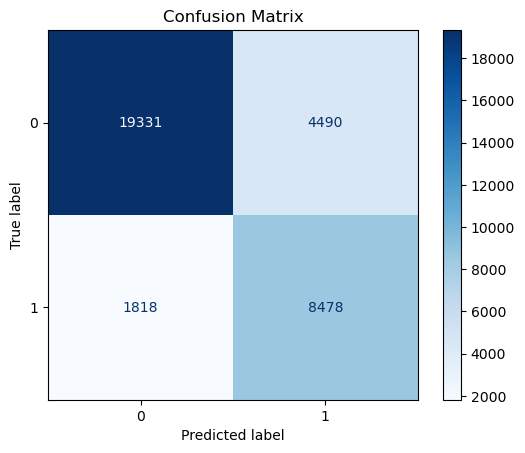

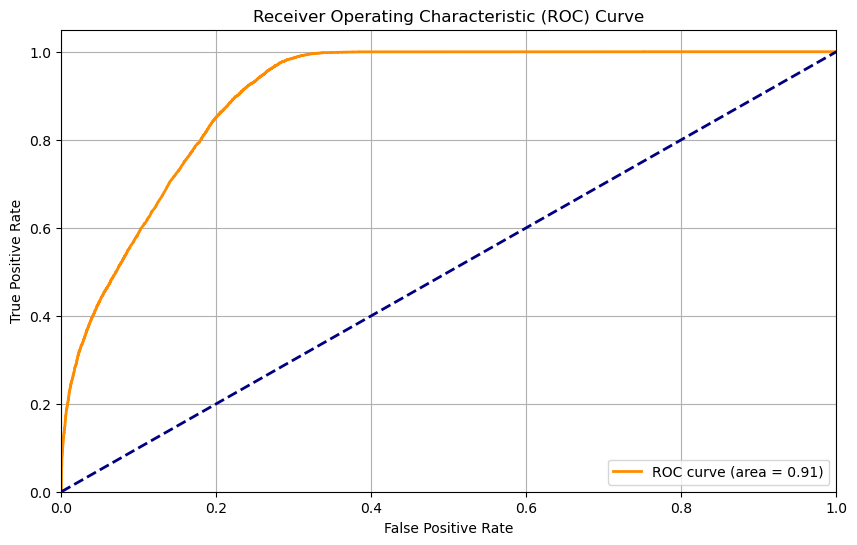

Overall F1 Score: 0.8202

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     23821
           1       0.65      0.82      0.73     10296

    accuracy                           0.82     34117
   macro avg       0.78      0.82      0.79     34117
weighted avg       0.84      0.82      0.82     34117



In [8]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'cluster','num_tickets', 'std_days_between_orders','total_sales', 'total_quantity'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    lgb_classifier = lgb.LGBMClassifier(**param, random_state=42)
    lgb_classifier.fit(X_train, y_train)
    y_pred_proba = lgb_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=8)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_lgb_classifier = lgb.LGBMClassifier(**best_params, random_state=42)
best_lgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_lgb_classifier.predict(X_test)
y_pred_proba = best_lgb_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_lgb_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_lgb_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Random forest again without cluster

[I 2024-07-10 13:38:53,992] A new study created in memory with name: no-name-7b3c8beb-0f0e-444e-8421-d185b67031ea
[I 2024-07-10 13:39:30,135] Trial 4 finished with value: 0.9064662869210326 and parameters: {'n_estimators': 213, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 4 with value: 0.9064662869210326.
[I 2024-07-10 13:39:30,453] Trial 0 finished with value: 0.9051530880064527 and parameters: {'n_estimators': 160, 'max_depth': 16, 'min_samples_split': 16, 'min_samples_leaf': 13, 'bootstrap': False}. Best is trial 4 with value: 0.9064662869210326.
[I 2024-07-10 13:40:10,469] Trial 6 finished with value: 0.906674401935936 and parameters: {'n_estimators': 463, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 16, 'bootstrap': True}. Best is trial 6 with value: 0.906674401935936.
[I 2024-07-10 13:40:29,324] Trial 3 finished with value: 0.9049454704207864 and parameters: {'n_estimators': 500, 'max_depth': 35, 'min_samples_s

Best parameters found: {'n_estimators': 463, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 16, 'bootstrap': True}
Confusion Matrix:
[[19839  3982]
 [ 2316  7980]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     23821
           1       0.67      0.78      0.72     10296

    accuracy                           0.82     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.82      0.82     34117


Accuracy Score:
0.8153999472403787

ROC-AUC Score: 0.9067

Feature Importance:
                     feature  importance
2               total_period    0.543958
6                num_tickets    0.130749
7    std_days_between_orders    0.109354
3    avg_days_between_orders    0.089185
4             avg_sale_value    0.053424
5                clv_monthly    0.044331
0            unique_branches    0.024152
1  percentage_negative_sales    0.004848


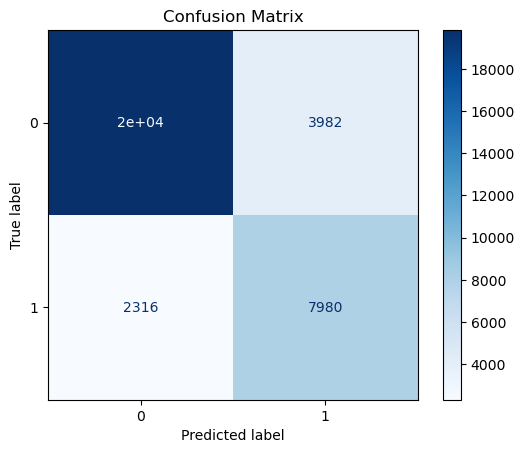

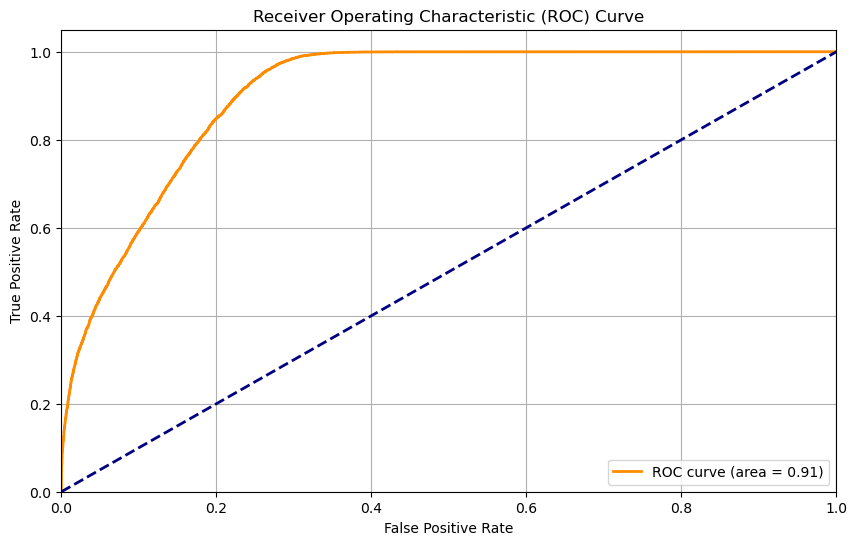

Overall F1 Score: 0.8190

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     23821
           1       0.67      0.78      0.72     10296

    accuracy                           0.82     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.82      0.82     34117



In [6]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it is already loaded
# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_sale_value',
    'clv_monthly',
    'num_tickets', 'std_days_between_orders'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=8)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
df1=pd.read_csv('client_cleaned_churn')

In [11]:
df['avg_monthly_sales']=df['avg_montly_sales']

In [12]:
df=df.drop(columns='avg_montly_sales')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170581 entries, 0 to 170580
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   client_id                   170581 non-null  int32  
 1   first_order_date            170581 non-null  object 
 2   last_order_date             170581 non-null  object 
 3   total_sales                 170581 non-null  float64
 4   total_quantity              170581 non-null  int32  
 5   num_tickets                 170581 non-null  int16  
 6   num_negative_tickets        170581 non-null  int8   
 7   unique_branches             170581 non-null  int16  
 8   max_days_between_orders     170581 non-null  float32
 9   total_period                170581 non-null  int16  
 10  recency                     170581 non-null  int16  
 11  avg_days_between_orders     170581 non-null  float32
 12  std_days_between_orders     170581 non-null  float32
 13  monthly_freque

[I 2024-07-10 14:01:41,511] A new study created in memory with name: no-name-f6275fb0-0732-4ab2-906a-e7b31e898f66
[I 2024-07-10 14:02:04,662] Trial 2 finished with value: 0.9000339275280503 and parameters: {'n_estimators': 220, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 14, 'bootstrap': True}. Best is trial 2 with value: 0.9000339275280503.
[I 2024-07-10 14:02:22,833] Trial 8 finished with value: 0.898332589065031 and parameters: {'n_estimators': 152, 'max_depth': 43, 'min_samples_split': 8, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 2 with value: 0.9000339275280503.
[I 2024-07-10 14:02:37,560] Trial 1 finished with value: 0.8981753524987437 and parameters: {'n_estimators': 317, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 13, 'bootstrap': False}. Best is trial 2 with value: 0.9000339275280503.
[I 2024-07-10 14:02:48,578] Trial 6 finished with value: 0.895304637407194 and parameters: {'n_estimators': 345, 'max_depth': 39, 'min_samples_sp

Best parameters found: {'n_estimators': 866, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 19, 'bootstrap': True}
Confusion Matrix:
[[19538  4283]
 [ 2237  8059]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.65      0.78      0.71     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.78     34117
weighted avg       0.82      0.81      0.81     34117


Accuracy Score:
0.8088929272796553

ROC-AUC Score: 0.9003

Feature Importance:
                     feature  importance
2               total_period    0.673009
5                num_tickets    0.161768
3             total_quantity    0.078782
4          avg_monthly_sales    0.058721
0            unique_branches    0.023383
1  percentage_negative_sales    0.004337


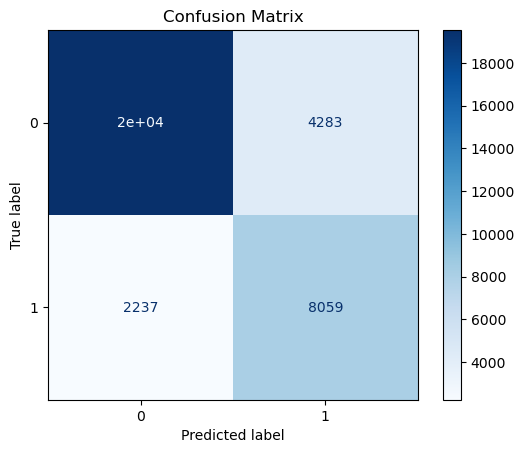

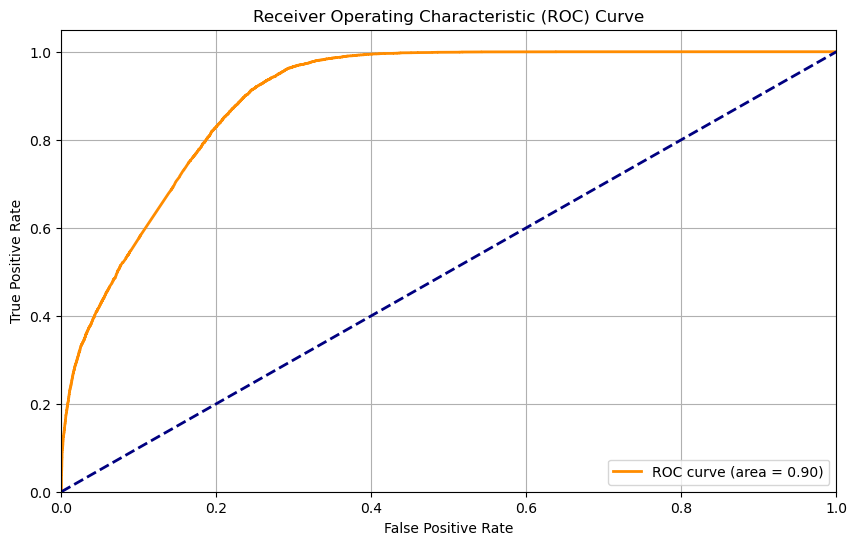

Overall F1 Score: 0.8132

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.65      0.78      0.71     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.78     34117
weighted avg       0.82      0.81      0.81     34117



In [14]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it is already loaded
# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'total_quantity',
    'avg_monthly_sales',
    'num_tickets'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=8)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[I 2024-07-10 14:21:39,419] A new study created in memory with name: no-name-b0e17bd8-7ece-4cc6-8527-9d1dcc0bfe96
[I 2024-07-10 14:22:15,002] Trial 7 finished with value: 0.899640248982741 and parameters: {'n_estimators': 293, 'max_depth': 23, 'min_samples_split': 15, 'min_samples_leaf': 17, 'bootstrap': True}. Best is trial 7 with value: 0.899640248982741.
[I 2024-07-10 14:22:43,867] Trial 0 finished with value: 0.8996089741388008 and parameters: {'n_estimators': 525, 'max_depth': 42, 'min_samples_split': 5, 'min_samples_leaf': 15, 'bootstrap': True}. Best is trial 7 with value: 0.899640248982741.
[I 2024-07-10 14:22:48,138] Trial 6 finished with value: 0.8973107858282705 and parameters: {'n_estimators': 360, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 7 with value: 0.899640248982741.
[I 2024-07-10 14:23:32,060] Trial 10 finished with value: 0.8999857849402368 and parameters: {'n_estimators': 416, 'max_depth': 12, 'min_samples_sp

Best parameters found: {'n_estimators': 628, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 19, 'bootstrap': True}
Confusion Matrix:
[[19516  4305]
 [ 2196  8100]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.65      0.79      0.71     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.82      0.81      0.81     34117


Accuracy Score:
0.8094498343934109

ROC-AUC Score: 0.9003

Feature Importance:
                     feature  importance
2               total_period    0.594599
6                num_tickets    0.161185
4    avg_days_between_orders    0.108844
3             total_quantity    0.075947
5          avg_monthly_sales    0.036440
0            unique_branches    0.019878
1  percentage_negative_sales    0.003107


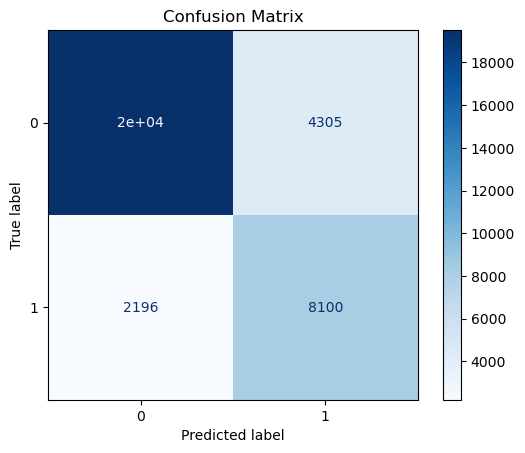

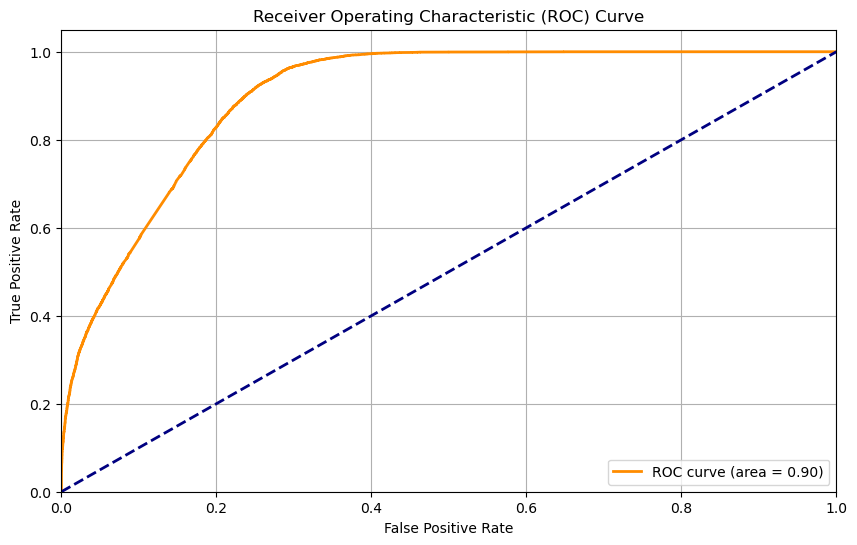

Overall F1 Score: 0.8139

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23821
           1       0.65      0.79      0.71     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.82      0.81      0.81     34117



In [15]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it is already loaded
# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'total_quantity',
    'avg_days_between_orders',
    'avg_monthly_sales',
    'num_tickets'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=8)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[I 2024-07-10 14:48:40,127] A new study created in memory with name: no-name-acc34189-a51c-4c69-bf2b-3c1e25b4fc00
[I 2024-07-10 14:49:34,316] Trial 5 finished with value: 0.9044538717070307 and parameters: {'n_estimators': 413, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 17, 'bootstrap': True}. Best is trial 5 with value: 0.9044538717070307.
[I 2024-07-10 14:49:55,800] Trial 1 finished with value: 0.9035184030225172 and parameters: {'n_estimators': 374, 'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 14, 'bootstrap': False}. Best is trial 5 with value: 0.9044538717070307.
[I 2024-07-10 14:50:01,609] Trial 2 finished with value: 0.9033423640388084 and parameters: {'n_estimators': 402, 'max_depth': 42, 'min_samples_split': 16, 'min_samples_leaf': 13, 'bootstrap': False}. Best is trial 5 with value: 0.9044538717070307.
[I 2024-07-10 14:50:24,581] Trial 6 finished with value: 0.9040212652466546 and parameters: {'n_estimators': 763, 'max_depth': 27, 'min_samp

Best parameters found: {'n_estimators': 590, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 17, 'bootstrap': True}
Confusion Matrix:
[[19438  4383]
 [ 1990  8306]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     23821
           1       0.65      0.81      0.72     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.81      0.79     34117
weighted avg       0.83      0.81      0.82     34117


Accuracy Score:
0.8132016296860802

ROC-AUC Score: 0.9046

Feature Importance:
                     feature  importance
2               total_period    0.541483
6                num_tickets    0.123325
7    std_days_between_orders    0.110804
4    avg_days_between_orders    0.087294
3             total_quantity    0.076193
5          avg_monthly_sales    0.038936
0            unique_branches    0.017816
1  percentage_negative_sales    0.004149


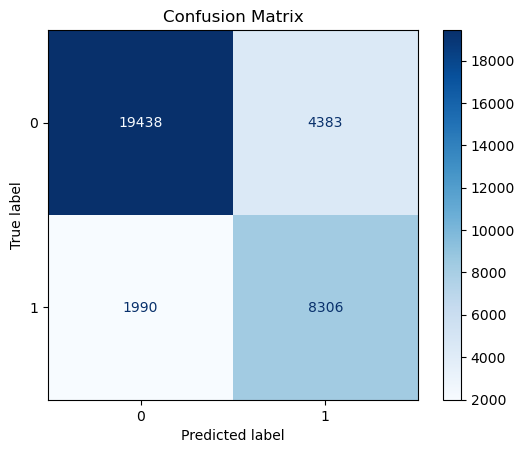

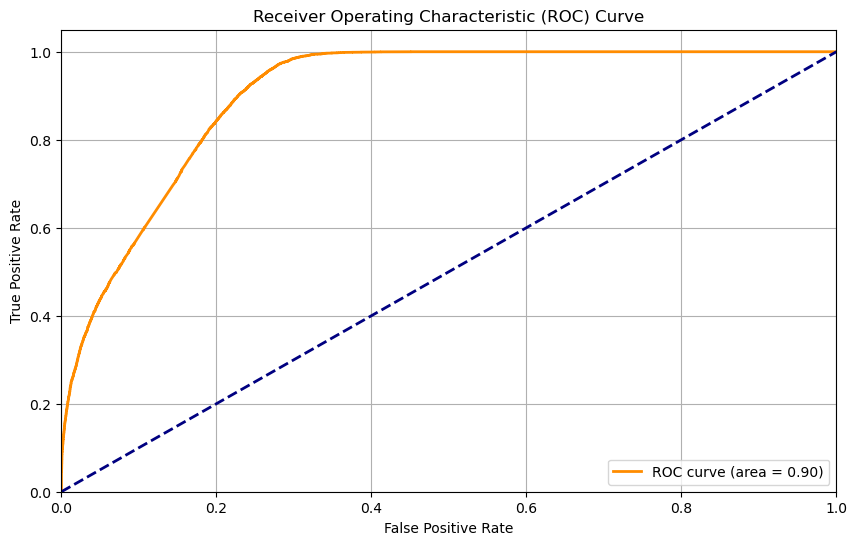

Overall F1 Score: 0.8180

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     23821
           1       0.65      0.81      0.72     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.81      0.79     34117
weighted avg       0.83      0.81      0.82     34117



In [16]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it is already loaded
# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'total_quantity',
    'avg_days_between_orders',
    'avg_monthly_sales',
    'num_tickets',
    'std_days_between_orders'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=8)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[I 2024-07-10 16:32:29,088] A new study created in memory with name: no-name-e2393548-1945-481c-ada3-0a58a05a80dc
[I 2024-07-10 16:33:08,627] Trial 1 finished with value: 0.9015417313610083 and parameters: {'n_estimators': 258, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 1 with value: 0.9015417313610083.
[I 2024-07-10 16:33:20,429] Trial 7 finished with value: 0.9020644275566402 and parameters: {'n_estimators': 341, 'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 7 with value: 0.9020644275566402.
[I 2024-07-10 16:33:49,518] Trial 4 finished with value: 0.8975619488585989 and parameters: {'n_estimators': 456, 'max_depth': 49, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 7 with value: 0.9020644275566402.
[I 2024-07-10 16:33:54,533] Trial 9 finished with value: 0.8982570960237726 and parameters: {'n_estimators': 136, 'max_depth': 29, 'min_samples_sp

Best parameters found: {'n_estimators': 280, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 7, 'bootstrap': True}
Confusion Matrix:
[[19696  4125]
 [ 2280  8016]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     23821
           1       0.66      0.78      0.71     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.81      0.82     34117


Accuracy Score:
0.8122636808629129

ROC-AUC Score: 0.9024

Feature Importance:
                     feature  importance
2               total_period    0.530140
6                num_tickets    0.120435
4    avg_days_between_orders    0.100511
7                total_sales    0.095183
3             total_quantity    0.064235
5          avg_monthly_sales    0.064069
0            unique_branches    0.020241
1  percentage_negative_sales    0.005187


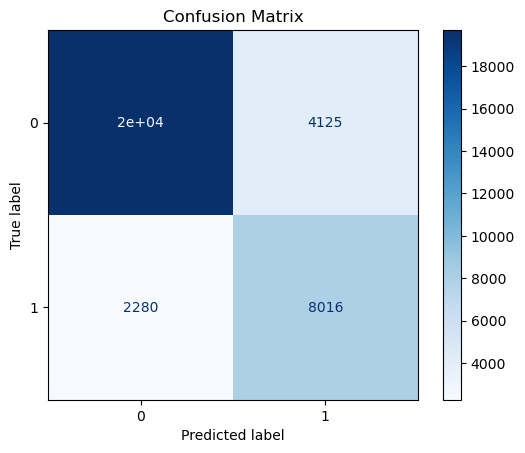

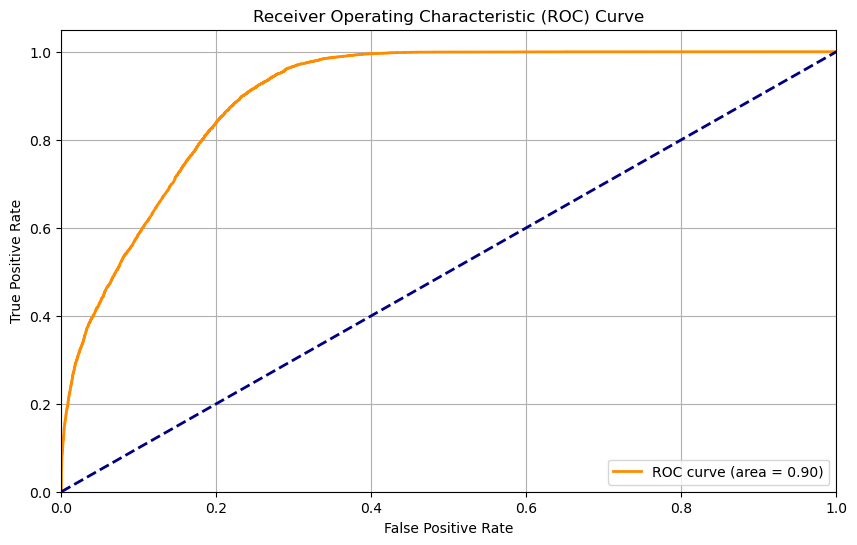

Overall F1 Score: 0.8162

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     23821
           1       0.66      0.78      0.71     10296

    accuracy                           0.81     34117
   macro avg       0.78      0.80      0.79     34117
weighted avg       0.83      0.81      0.82     34117



In [17]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it is already loaded
# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'total_quantity',
    'avg_days_between_orders',
    'avg_monthly_sales',
    'num_tickets',
    'total_sales'
]

target_column = 'churn_max'

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=8)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Trying with outliers included

In [18]:
df1=pd.read_csv('client_cleaned_churn')

In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170589 entries, 0 to 170588
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  170589 non-null  int64  
 1   client_id                   170589 non-null  int64  
 2   first_order_date            170589 non-null  object 
 3   last_order_date             170589 non-null  object 
 4   total_sales                 170589 non-null  float64
 5   total_quantity              170589 non-null  int64  
 6   num_tickets                 170589 non-null  int64  
 7   num_negative_tickets        170589 non-null  int64  
 8   unique_branches             170589 non-null  int64  
 9   max_days_between_orders     170589 non-null  float64
 10  total_period                170589 non-null  int64  
 11  recency                     170589 non-null  int64  
 12  avg_days_between_orders     170589 non-null  float64
 13  std_days_betwe

In [20]:
df1=df1.drop(columns='Unnamed: 0')

In [21]:
df1['avg_monthly_sales']=df1['clv_monthly']

In [22]:
df1=df1.drop(columns='clv_monthly')

[I 2024-07-10 16:51:01,195] A new study created in memory with name: no-name-4b8d67b8-09da-453b-ab8c-ea1b293bb630
[I 2024-07-10 16:51:19,100] Trial 2 finished with value: 0.9005134651858231 and parameters: {'n_estimators': 106, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 11, 'bootstrap': True}. Best is trial 2 with value: 0.9005134651858231.
[I 2024-07-10 16:51:42,577] Trial 6 finished with value: 0.8959712337014712 and parameters: {'n_estimators': 221, 'max_depth': 46, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 2 with value: 0.9005134651858231.
[I 2024-07-10 16:52:09,450] Trial 7 finished with value: 0.9019633869740725 and parameters: {'n_estimators': 466, 'max_depth': 17, 'min_samples_split': 20, 'min_samples_leaf': 20, 'bootstrap': True}. Best is trial 7 with value: 0.9019633869740725.
[I 2024-07-10 16:52:14,975] Trial 1 finished with value: 0.902001874884806 and parameters: {'n_estimators': 492, 'max_depth': 16, 'min_samples_sp

Best parameters found: {'n_estimators': 863, 'max_depth': 14, 'min_samples_split': 16, 'min_samples_leaf': 5, 'bootstrap': True}
Confusion Matrix:
[[19673  4193]
 [ 2198  8054]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23866
           1       0.66      0.79      0.72     10252

    accuracy                           0.81     34118
   macro avg       0.78      0.80      0.79     34118
weighted avg       0.83      0.81      0.82     34118


Accuracy Score:
0.812679524004924

ROC-AUC Score: 0.9023

Feature Importance:
                     feature  importance
2               total_period    0.518026
6                num_tickets    0.123491
4    avg_days_between_orders    0.105349
7                total_sales    0.101080
3             total_quantity    0.065148
5          avg_monthly_sales    0.064758
0            unique_branches    0.016645
1  percentage_negative_sales    0.005502


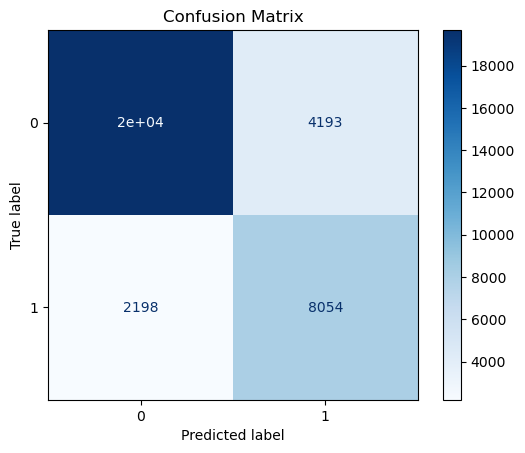

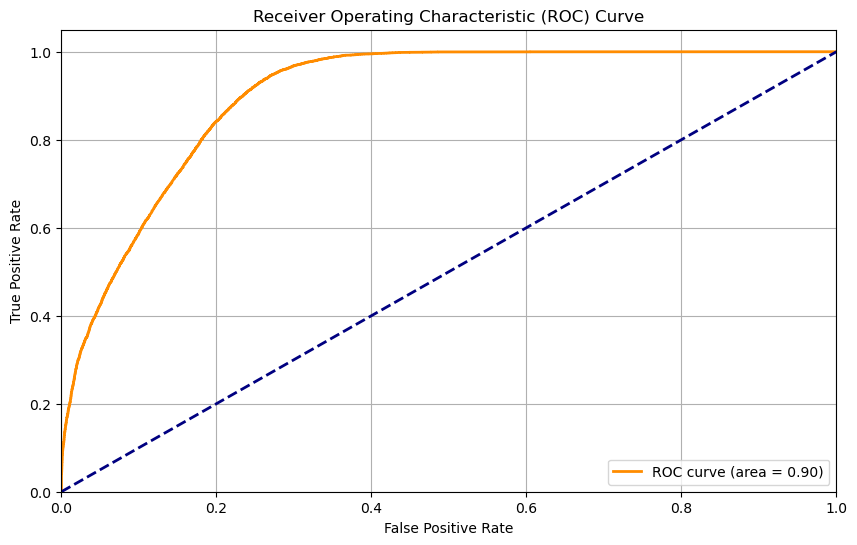

Overall F1 Score: 0.8169

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     23866
           1       0.66      0.79      0.72     10252

    accuracy                           0.81     34118
   macro avg       0.78      0.80      0.79     34118
weighted avg       0.83      0.81      0.82     34118



In [23]:

# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'total_quantity',
    'avg_days_between_orders',
    'avg_monthly_sales',
    'num_tickets',
    'total_sales'
]

target_column = 'churn_max'

# Select the features and the target
X = df1[feature_columns]
y = df1[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=8)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[I 2024-07-10 17:15:55,825] A new study created in memory with name: no-name-46b3c35f-6fb9-4c83-bb6e-c6213cc20e75
[I 2024-07-10 17:16:48,002] Trial 0 finished with value: 0.9004205395850594 and parameters: {'n_estimators': 348, 'max_depth': 32, 'min_samples_split': 14, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 0 with value: 0.9004205395850594.
[I 2024-07-10 17:17:17,425] Trial 7 finished with value: 0.8909983132183694 and parameters: {'n_estimators': 312, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.9004205395850594.
[I 2024-07-10 17:17:19,604] Trial 1 finished with value: 0.8992258551362287 and parameters: {'n_estimators': 519, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 0.9004205395850594.
[I 2024-07-10 17:17:20,230] Trial 4 finished with value: 0.9002344717689766 and parameters: {'n_estimators': 545, 'max_depth': 30, 'min_samples_sp

Best parameters found: {'n_estimators': 924, 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 11, 'bootstrap': True}
Confusion Matrix:
[[19750  4116]
 [ 2244  8008]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     23866
           1       0.66      0.78      0.72     10252

    accuracy                           0.81     34118
   macro avg       0.78      0.80      0.79     34118
weighted avg       0.83      0.81      0.82     34118


Accuracy Score:
0.8135881352951522

ROC-AUC Score: 0.9022

Feature Importance:
                     feature  importance
2               total_period    0.568950
5                num_tickets    0.140599
6                total_sales    0.111582
4          avg_monthly_sales    0.089518
3             total_quantity    0.067801
0            unique_branches    0.016409
1  percentage_negative_sales    0.005142


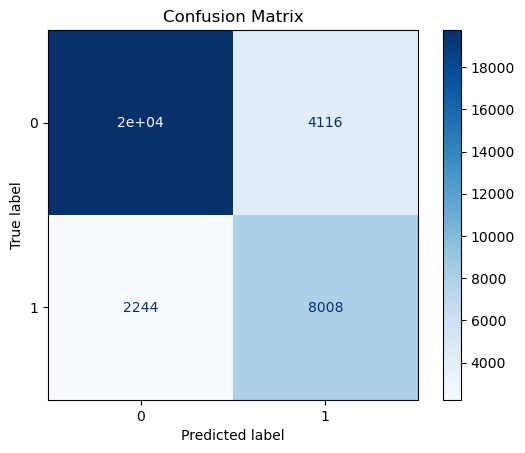

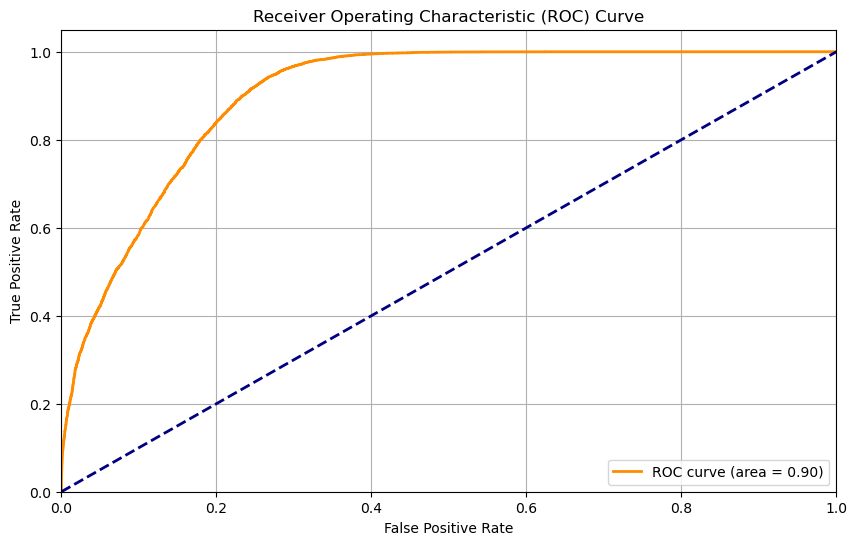

Overall F1 Score: 0.8176

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     23866
           1       0.66      0.78      0.72     10252

    accuracy                           0.81     34118
   macro avg       0.78      0.80      0.79     34118
weighted avg       0.83      0.81      0.82     34118



In [24]:

# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'total_quantity',
    'avg_monthly_sales',
    'num_tickets',
    'total_sales'
]

target_column = 'churn_max'

# Select the features and the target
X = df1[feature_columns]
y = df1[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    rf_classifier.fit(X_train, y_train)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=8)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters found: {best_params}")

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Optional: Feature importance
importances = best_rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calculate the overall F1 score
overall_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")

# Optional: Print the classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

### Final model training 

In [ ]:

# Define the feature columns and the target column
feature_columns = [
    'unique_branches', 'percentage_negative_sales',
    'total_period',
    'avg_days_between_orders',
    'avg_monthly_sales',
    'num_tickets', 'total_sales', 'total_quantity'
]

target_column = 'churn_max'

# Best parameters found previously
best_params = {
    'n_estimators': 956,
    'max_depth': 23,
    'min_samples_split': 3,
    'min_samples_leaf': 20,
    'bootstrap': True
}

# Select the features and the target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Retrain the Random Forest classifier with the best parameters
rf_classifier = RandomForestClassifier(**best_params, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict churn probabilities
df['churn_proba'] = rf_classifier.predict_proba(X)[:, 1]

# Create a new column by multiplying churn_proba by clv_monthly
df['churn_proba_monetary'] = df['churn_proba'] * df['avg_monthly_sales']

# Display the first few rows to check the new columns
df.head()

# Optionally, save the updated dataframe to a new CSV file
df.to_csv('updated_df_with_churn_proba.csv', index=False)